In [1]:
import pandas as pd
import string
import re
from textblob import TextBlob
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_validate

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers, Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

In [52]:
from gensim.models import Word2Vec
from tensorflow.keras.preprocessing.text import text_to_word_sequence
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.metrics import top_k_accuracy_score
import gensim.downloader as api
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.regularizers import l2
from keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Concatenate, Dropout, Dense, Activation, Masking


In [4]:
df_test = pd.read_csv('../raw_data/titles_data/titles_test_trnls.csv')
df_train = pd.read_csv('../raw_data/titles_data/titles_train_trnls.csv')

In [5]:
df_train.head(10)

,Image_name,Title,translated_title
0,1588345297.jpg,"Colet example, and SA sported ronals Gentl Twi...","Colet example, and SA sported ronals Gentl Twi..."
1,1404803335.jpg,Maghets Pulling Together Pushing Apart,Maghets Pulling Together Pushing Apart
2,1446276082.jpg,ENERGY SECURITY VOLUME SAGE LIBRARY OF INTERNA...,ENERGY SECURITY VOLUME SAGE LIBRARY OF INTERNA...
3,1491522666.jpg,AUDIOBOOK MP3-CD Insert Transfer Listen! TREES...,AUDIOBOOK MP3-CD Insert Transfer Listen! TREES...
4,0970096410.jpg,City of Rocks Idaho A Climber's Guide untale,City of Rocks Idaho A Climber's Guide untale
5,8436808053.jpg,CÓMO VENCER EL INSOMNIO MARIANO CHOLIZ MONTANE...,HOW TO BEAT INSOMNIA MARIANO CHOLIZ MONTANES T...
6,1848291388.jpg,JOHN MARTIN LITTLEJOHN by John Den AN ENIGMA O...,JOHN MARTIN LITTLEJOHN by John Den AN ENIGMA O...
7,0073402656.jpg,CH EMISTRY De Molar ata Silberberg,CH EMISTRY De Molar ata Silberberg
8,0323045979.jpg,Mosby's ONCOLOGY NURSING ADVISOR A Comprehensi...,Mosby's ONCOLOGY NURSING ADVISOR A Comprehensi...
9,1847176968.jpg,IRELAND'S WILD ATLANTIC WAY Carsten Krieger,IRELAND'S WILD ATLANTIC WAY Carsten Krieger


In [6]:
def count_special_chars(s):
    if isinstance(s, str):
        return sum(1 for c in s if c == ':' or c == '-')
    return 0

special_char_counts = df_train["translated_title"].apply(count_special_chars)
df_train['special_chars'] = special_char_counts.apply(lambda count: 1 if count > 0 else 0)

special_char_counts = df_test["translated_title"].apply(count_special_chars)
df_test['special_chars'] = special_char_counts.apply(lambda count: 1 if count > 0 else 0)


In [7]:
def count_commas(s):
    if isinstance(s, str):
        return sum(1 for c in s if c == ',')
    return 0

commas_counts = df_train["translated_title"].apply(count_commas)
df_train['commas'] = commas_counts.apply(lambda count: 1 if count > 0 else 0)

commas_counts = df_test["translated_title"].apply(count_commas)
df_test['commas'] = commas_counts.apply(lambda count: 1 if count > 0 else 0)

In [8]:
df_train

,Image_name,Title,translated_title,special_chars,commas
0,1588345297.jpg,"Colet example, and SA sported ronals Gentl Twi...","Colet example, and SA sported ronals Gentl Twi...",1,1
1,1404803335.jpg,Maghets Pulling Together Pushing Apart,Maghets Pulling Together Pushing Apart,0,0
2,1446276082.jpg,ENERGY SECURITY VOLUME SAGE LIBRARY OF INTERNA...,ENERGY SECURITY VOLUME SAGE LIBRARY OF INTERNA...,0,0
3,1491522666.jpg,AUDIOBOOK MP3-CD Insert Transfer Listen! TREES...,AUDIOBOOK MP3-CD Insert Transfer Listen! TREES...,1,0
4,0970096410.jpg,City of Rocks Idaho A Climber's Guide untale,City of Rocks Idaho A Climber's Guide untale,0,0
...,...,...,...,...,...
51295,0399176055.jpg,JOHN SANDFORD NEW YORK TIMES-BESTSELLING AUTHO...,JOHN SANDFORD NEW YORK TIMES-BESTSELLING AUTHO...,1,0
51296,0719816629.jpg,SECOND EDITION THE CRIME WRITER'S GUIDE TO POL...,SECOND EDITION THE CRIME WRITER'S GUIDE TO POL...,0,0
51297,0385353596.jpg,THE JEZEBEL REMEDY A Nord MARTIN CLARK,THE JEZEBEL REMEDY A Nord MARTIN CLARK,0,0
51298,1475988559.jpg,STARTUP GLENN OGURA,GLENN OGURA'S STARTUP,0,0


In [9]:
df_test

,Image_name,Title,translated_title,special_chars,commas
0,044310073X.jpg,Sereed Camion Oral and Maxillofacial Surgery A...,Sereed Camion Oral and Maxillofacial Surgery A...,1,0
1,1438005687.jpg,BARRON'S The Leader in Test Preparation GRE MO...,BARRON'S The Leader in Test Preparation GRE MO...,1,0
2,0060750715.jpg,The Ballet Maker wwww. George Balanchine Rober...,The Ballet Maker wwww. George Balanchine Rober...,0,0
3,1580237959.jpg,INSTITUTE FOR JEWISH SPIRITUALITY SERIES A PAR...,INSTITUTE FOR JEWISH SPIRITUALITY SERIES A PAR...,0,1
4,0135137829.jpg,Tu Oce P and P and Co acred Construction Sched...,Tu Oce P and P and Co acred Construction Sched...,0,0
...,...,...,...,...,...
5695,0399174680.jpg,#1 NEW YORK TIMES BESTSELLING AUTHOR STUART WO...,#1 NEW YORK TIMES BESTSELLING AUTHOR STUART WO...,0,0
5696,1939454654.jpg,STORIES FROM THE AGE OF DISTRACTION VOLUME ONE...,STORIES FROM THE AGE OF DISTRACTION VOLUME ONE...,0,0
5697,1604601604.jpg,Fifth Moved in the Culasidge Community Series ...,Fifth Moved in the Culasidge Community Series ...,1,0
5698,0399166726.jpg,WX -LIBA Saving Jason MICHAEL SEARS BLACK FRIDAYS,WX -LIBA Saving Jason MICHAEL SEARS BLACK FRIDAYS,1,0


In [10]:
def preprocessed_title(titles):
    output = titles.str.lower()
    output = output.apply(lambda x: "".join([i for i in x if i not in string.punctuation]))
    output = output.apply(lambda x: "".join([i for i in x if i not in string.digits]))
    output = output.apply(lambda x: re.split('\W+', x))
    #output = output.apply(lambda x: [str(TextBlob(word).correct()) for word in x])
    porter_stemmer = PorterStemmer()
    output = output.apply(lambda x: [porter_stemmer.stem(word) for word in x])
    stops = set(stopwords.words('english'))
    output = output.apply(lambda x: [word for word in x if word not in stops])

    return output

In [11]:
X_train_preproc = preprocessed_title(df_train['translated_title'].fillna(''))

In [12]:
X_test_preproc = preprocessed_title(df_test['translated_title'].fillna(''))

In [13]:
X_train_preproc.head(10)

0    [colet, exampl, sa, sport, ronal, gentl, twitt...
1                  [maghet, pull, togeth, push, apart]
2    [energi, secur, volum, sage, librari, intern, ...
3    [audiobook, mpcd, insert, transfer, listen, tr...
4            [citi, rock, idaho, climber, guid, untal]
5    [beat, insomnia, mariano, choliz, montan, tech...
6    [john, martin, littlejohn, john, den, enigma, ...
7            [ch, emistri, de, molar, ata, silberberg]
8    [mosbi, oncolog, nurs, advisor, comprehens, gu...
9       [ireland, wild, atlant, way, carsten, krieger]
Name: translated_title, dtype: object

### Word2vec - trained directly on our text/titles

In [126]:
!pip freeze | grep gensim

gensim==4.2.0


In [127]:
!pip freeze | grep tensorflow

tensorflow==2.13.0rc1
tensorflow-datasets==4.6.0
tensorflow-estimator==2.13.0rc0
tensorflow-macos==2.13.0rc1
tensorflow-metadata==1.10.0


In [11]:
len(X_train_preproc)

51300

In [11]:
word2vec = Word2Vec(sentences=X_train_preproc, min_count=5, vector_size=50, window=10) 
#wv = word2vec.wv

In [12]:
print(word2vec.wv['leadership'])


[ 7.05255717e-02 -1.59899428e-01  7.91089609e-02  3.25199276e-01
 -3.75788271e-01 -8.87094960e-02  7.45653570e-01  8.43969882e-01
 -5.08478522e-01 -8.71459618e-02 -5.96109405e-02 -6.18718684e-01
 -2.71117330e-01  1.51707754e-01 -5.97222932e-02  8.21534321e-02
  6.28328249e-02 -2.77987570e-01 -5.43161035e-01 -2.35641882e-01
 -3.22878629e-01  3.13255042e-01  4.63393420e-01 -4.06247616e-01
  3.20008397e-01  1.04992576e-01 -6.16615653e-01 -4.09085155e-01
 -2.53753752e-01 -5.65642677e-02  1.39818102e-01 -4.85663824e-02
  3.05977225e-01  4.18715805e-01 -3.21396917e-01  1.80304646e-01
 -8.54053795e-02  7.91481137e-02 -1.83689035e-02 -2.96470582e-01
  4.16545123e-01 -1.36862189e-01 -2.13938430e-01  3.49607086e-04
  7.78357685e-02 -8.99041221e-02 -4.81875718e-01  7.25263637e-03
  1.89643487e-01  5.49185812e-01]


In [13]:
word2vec.wv.most_similar('crime')

[('sherlock', 0.9601949453353882),
 ('fiction', 0.9513843059539795),
 ('black', 0.9488809108734131),
 ('origin', 0.9486808180809021),
 ('scalzi', 0.944512665271759),
 ('white', 0.9420084357261658),
 ('homefront', 0.9349239468574524),
 ('jedi', 0.928596556186676),
 ('holm', 0.9283366799354553),
 ('detect', 0.9272217154502869)]

In [14]:
word2vec.wv.vectors.shape

(12470, 50)

In [15]:
# Functions to return list of embedded sentences (each sentence as a matrix)

# Function to convert a sentence (list of words) into a matrix representing the words in the embedding space
def embed_sentence(word2vec, sentence):
    embedded_sentence = []
    for word in sentence:
        if word in word2vec.wv:
            embedded_sentence.append(word2vec.wv[word])
        
    return np.array(embedded_sentence)

# Function that converts a list of sentences into a list of matrices
def embedding(word2vec, sentences):
    embed = []
    
    for sentence in sentences:
        embedded_sentence = embed_sentence(word2vec, sentence)
        embed.append(embedded_sentence)
        
    return embed

In [16]:
# Embed the training and test sentences
X_train_embed = embedding(word2vec, X_train_preproc)
X_test_embed = embedding(word2vec, X_test_preproc)

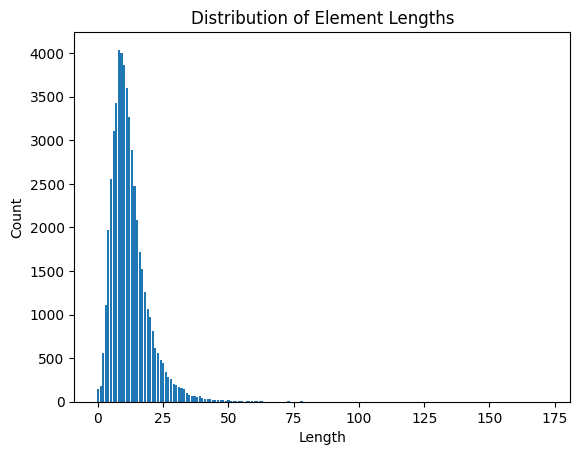

In [17]:
# Count the lengths of elements in the list
lengths = [len(element) for element in X_train_preproc]
length_counts = Counter(lengths)

# Extract the lengths and counts for plotting
x = list(length_counts.keys())
y = list(length_counts.values())

# Plot the bar graph
plt.bar(x, y)
plt.xlabel('Length')
plt.ylabel('Count')
plt.title('Distribution of Element Lengths')
plt.show()

In [18]:
len(max(X_train_preproc, key=len))

172

In [19]:
# Pad the training and test embedded sentences
X_train_pad = pad_sequences(X_train_embed, dtype='float32', padding='post', maxlen=100)
X_test_pad = pad_sequences(X_test_embed, dtype='float32', padding='post', maxlen=100)

In [20]:
# TEST ME
for X in [X_train_pad, X_test_pad]:
    assert type(X) == np.ndarray
    assert X.shape[-1] == word2vec.wv.vector_size


assert X_train_pad.shape[0] == len(X_train_preproc)
assert X_test_pad.shape[0] == len(X_test_preproc)

### y target preperoc

In [29]:
y_train = np.load('../raw_data/tmp_data/train_y_prep.npy', encoding='bytes', allow_pickle=True)
# shape (51300, 30)

In [30]:
y_test = np.load('../raw_data/tmp_data/test_y_prep.npy', encoding='bytes', allow_pickle=True)
# shape (5700, 30)

In [31]:
print(X_train_pad.shape, y_train.shape)
print(X_test_pad.shape, y_test.shape)

(51300, 100, 50) (51300, 30)
(5700, 100, 50) (5700, 30)


In [32]:
y_train_umbr = np.load("../raw_data/tmp_data/y_train_umbr.npy", encoding='bytes', allow_pickle=True)
y_train_umbr_df = pd.DataFrame(y_train_umbr)
y_train_umbr_df = y_train_umbr_df.rename(columns={
    y_train_umbr_df.columns[0]: 'Genre_id',
    y_train_umbr_df.columns[1]: 'Genre_name',
    y_train_umbr_df.columns[2]: 'Genre_umbr_name',
    y_train_umbr_df.columns[3]: 'Genre_umbr_id'
})

#y_umbr = y_umbr.rename_axis('Genre_id')
y_train_umbr_df['Genre_umbr_id'] = y_train_umbr_df['Genre_umbr_id'] - 1
y_train_umbr_df

,Genre_id,Genre_name,Genre_umbr_name,Genre_umbr_id
0,1,Biographies & Memoirs,History & Religion,0
1,4,Children's Books,Relationships & Children,1
2,10,Engineering & Transportation,Academic - Science,2
3,9,Christian Books & Bibles,History & Religion,0
4,26,Sports & Outdoors,Lifestyle & Fitness,3
...,...,...,...,...
51295,17,"Mystery, Thriller & Suspense",Literature & Entertainment,4
51296,17,"Mystery, Thriller & Suspense",Literature & Entertainment,4
51297,17,"Mystery, Thriller & Suspense",Literature & Entertainment,4
51298,17,"Mystery, Thriller & Suspense",Literature & Entertainment,4


In [33]:
y_umbr_test = np.load("../raw_data/tmp_data/y_test_umbr.npy", encoding='bytes', allow_pickle=True)
y_umbr_test_df = pd.DataFrame(y_umbr_test)
y_umbr_test_df = y_umbr_test_df.rename(columns={
    y_umbr_test_df.columns[0]: 'Genre_id',
    y_umbr_test_df.columns[1]: 'Genre_name',
    y_umbr_test_df.columns[2]: 'Genre_umbr_name',
    y_umbr_test_df.columns[3]: 'Genre_umbr_id'
})

#y_umbr = y_umbr.rename_axis('Genre_id')
y_umbr_test_df['Genre_umbr_id'] = y_umbr_test_df['Genre_umbr_id'] - 1
y_umbr_test_df

,Genre_id,Genre_name,Genre_umbr_name,Genre_umbr_id
0,16,Medical Books,Academic - Science,2
1,28,Test Preparation,Academic - Pure,7
2,1,Biographies & Memoirs,History & Religion,0
3,21,Religion & Spirituality,History & Religion,0
4,0,Arts & Photography,Arts & Hobbies,6
...,...,...,...,...
5695,17,"Mystery, Thriller & Suspense",Literature & Entertainment,4
5696,17,"Mystery, Thriller & Suspense",Literature & Entertainment,4
5697,17,"Mystery, Thriller & Suspense",Literature & Entertainment,4
5698,17,"Mystery, Thriller & Suspense",Literature & Entertainment,4


In [34]:
y_train_umbr = y_train_umbr_df['Genre_umbr_id'].astype(int)
y_test_umbr = y_umbr_test_df['Genre_umbr_id'].astype(int)
print(y_train_umbr.shape, y_test_umbr.shape)
print(len(np.unique(y_train_umbr)))

(51300,) (5700,)
8


In [35]:
y_train_umbr -= 1
y_train_umbr = to_categorical(y_train_umbr, num_classes=8)

In [36]:
y_test_umbr -= 1
y_test_umbr = to_categorical(y_test_umbr, num_classes=8)

In [27]:
print(X_train_pad.shape, y_train.shape)
print(X_test_pad.shape, y_test.shape)

(51300, 100, 50) (51300, 30)
(5700, 100, 50) (5700, 30)


In [28]:
print(X_train_pad.shape, y_train_umbr.shape)
print(X_test_pad.shape, y_test_umbr.shape)

(51300, 100, 50) (51300, 8)
(5700, 100, 50) (5700, 8)


### Plot function

In [14]:
def plot_history(history, title='', axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    ax1.plot(history.history['loss'], label = 'train' + exp_name)
    ax1.plot(history.history['val_loss'], label = 'val' + exp_name)
    #ax1.set_ylim(0., 2.2)
    ax1.set_title('loss')
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='train accuracy'  + exp_name)
    ax2.plot(history.history['val_accuracy'], label='val accuracy'  + exp_name)
    #ax2.set_ylim(0.25, 1.)
    ax2.set_title('Accuracy')
    ax2.legend()
    return (ax1, ax2)

## Model RNN (word2vec trained on our text)

### 30 categories

In [74]:
def init_model():
    model = Sequential()
    model.add(layers.Masking())
    model.add(layers.LSTM(50, activation='tanh'))
    model.add(layers.Dropout(0.2))  
    #model.add(layers.LSTM(25, activation='tanh'))
    #model.add(layers.Dropout(0.2))  
    model.add(layers.Dense(15, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(layers.Dense(30, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    
    return model

model = init_model()

In [75]:
X_train_pad.shape

(51300, 100, 50)

In [76]:
es = EarlyStopping(patience=10, restore_best_weights=True, monitor='val_accuracy')

history = model.fit(X_train_pad, y_train, 
          batch_size = 32,
          epochs=100,
          validation_split=0.2,
          callbacks=[es]
         )

Epoch 1/100
1283/1283 [==============================] - 34s 25ms/step - loss: 2.9515 - accuracy: 0.1809 - val_loss: 3.0042 - val_accuracy: 0.1505
Epoch 2/100
1283/1283 [==============================] - 31s 24ms/step - loss: 2.7033 - accuracy: 0.2417 - val_loss: 2.9442 - val_accuracy: 0.1529
Epoch 3/100
1283/1283 [==============================] - 32s 25ms/step - loss: 2.6257 - accuracy: 0.2617 - val_loss: 2.8775 - val_accuracy: 0.1733
Epoch 4/100
1283/1283 [==============================] - 32s 25ms/step - loss: 2.5739 - accuracy: 0.2731 - val_loss: 2.8149 - val_accuracy: 0.1757
Epoch 5/100
1283/1283 [==============================] - 33s 25ms/step - loss: 2.5335 - accuracy: 0.2824 - val_loss: 2.8709 - val_accuracy: 0.1767
Epoch 6/100
1283/1283 [==============================] - 31s 24ms/step - loss: 2.5017 - accuracy: 0.2894 - val_loss: 2.7639 - val_accuracy: 0.1950
Epoch 7/100
1283/1283 [==============================] - 31s 24ms/step - loss: 2.4708 - accuracy: 0.2986 - val_loss: 2

(<AxesSubplot:title={'center':'loss'}>,
 <AxesSubplot:title={'center':'Accuracy'}>)

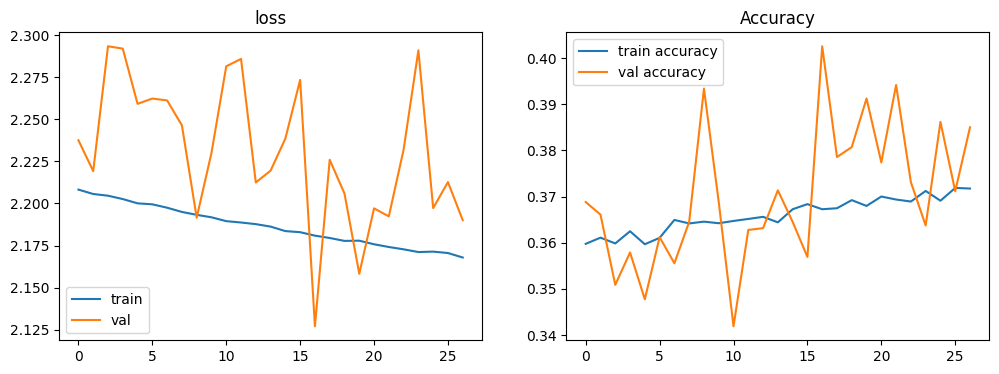

In [182]:
#plot_history(history)  # first model learning curves (rmsprop, batch 32, val split 0.1)

(<AxesSubplot:title={'center':'loss'}>,
 <AxesSubplot:title={'center':'Accuracy'}>)

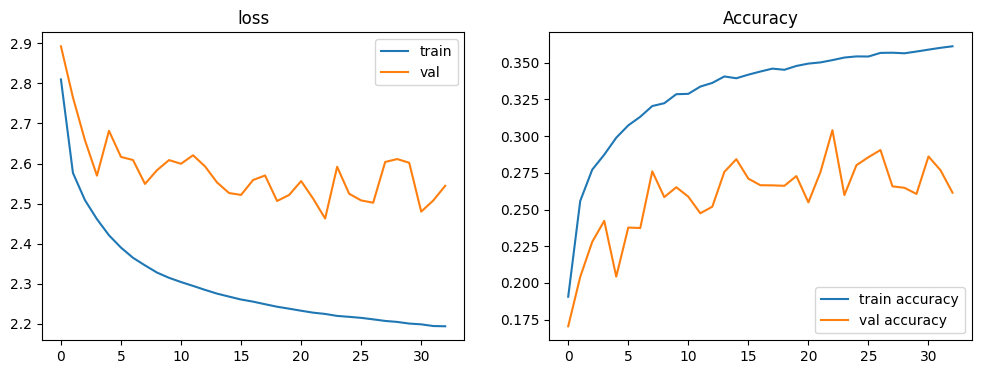

In [36]:
#plot_history(history) # plot history with adam, batch 16, valid.split 0.2 (no dropout or reguraliser)

(<AxesSubplot:title={'center':'loss'}>,
 <AxesSubplot:title={'center':'Accuracy'}>)

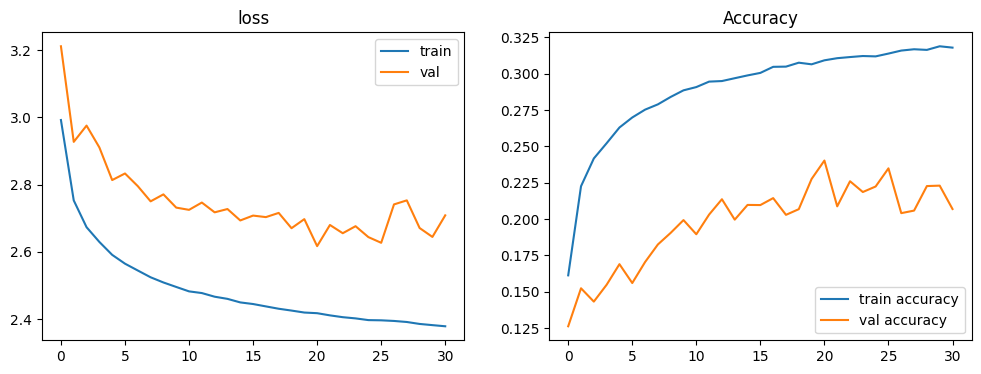

In [42]:
#plot_history(history) # plot like above + dropout and reguraliser

(<AxesSubplot:title={'center':'loss'}>,
 <AxesSubplot:title={'center':'Accuracy'}>)

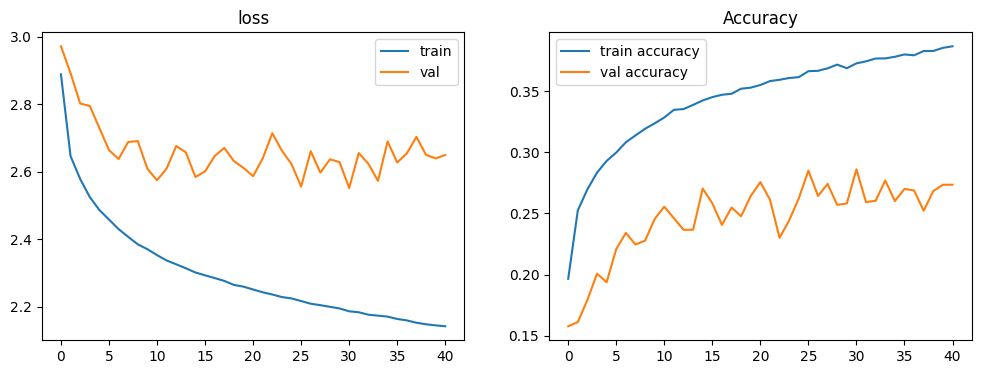

In [68]:
#plot_history(history) # above, but with lstm 50

(<AxesSubplot:title={'center':'loss'}>,
 <AxesSubplot:title={'center':'Accuracy'}>)

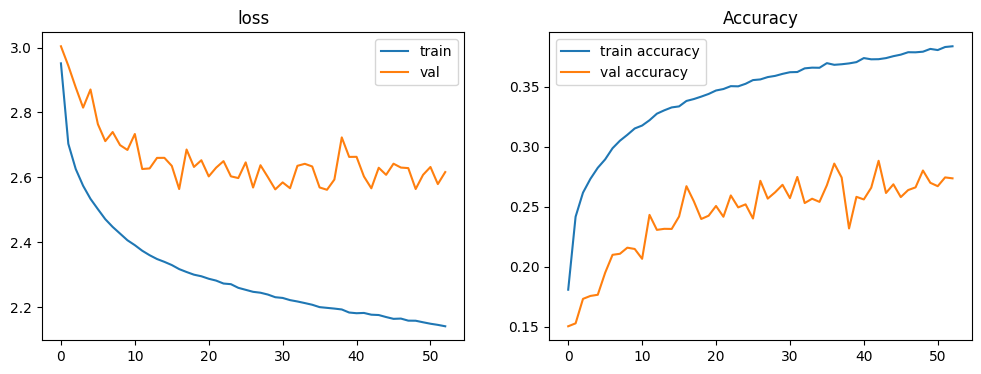

In [77]:
plot_history(history) # above, lstm 50 and batch 32 (not 16)

In [78]:
res = model.evaluate(X_test_pad, y_test, verbose=0)

print(f'The accuracy evaluated on the test set is of {res[1]*100:.3f}%')

The accuracy evaluated on the test set is of 32.298%


In [81]:
y_pred_full = model.predict(X_test_pad)
y_pred = np.argmax(y_pred_full, axis=1)

179/179 [==============================] - 2s 6ms/step


In [82]:
y_test_or = pd.read_csv("../raw_data/test_y.csv", delimiter=" ", index_col="Id")['Genre_id']
y_test_or

Id
0       16
1       28
2        1
3       21
4        0
        ..
5695    17
5696    17
5697    17
5698    17
5699    17
Name: Genre_id, Length: 5700, dtype: int64

In [83]:
top_k_accuracy = top_k_accuracy_score(y_test_or, y_pred_full, k=3)
print(f'Top 3 accuracy: {top_k_accuracy*100:.2f}%')

Top 3 accuracy: 54.11%


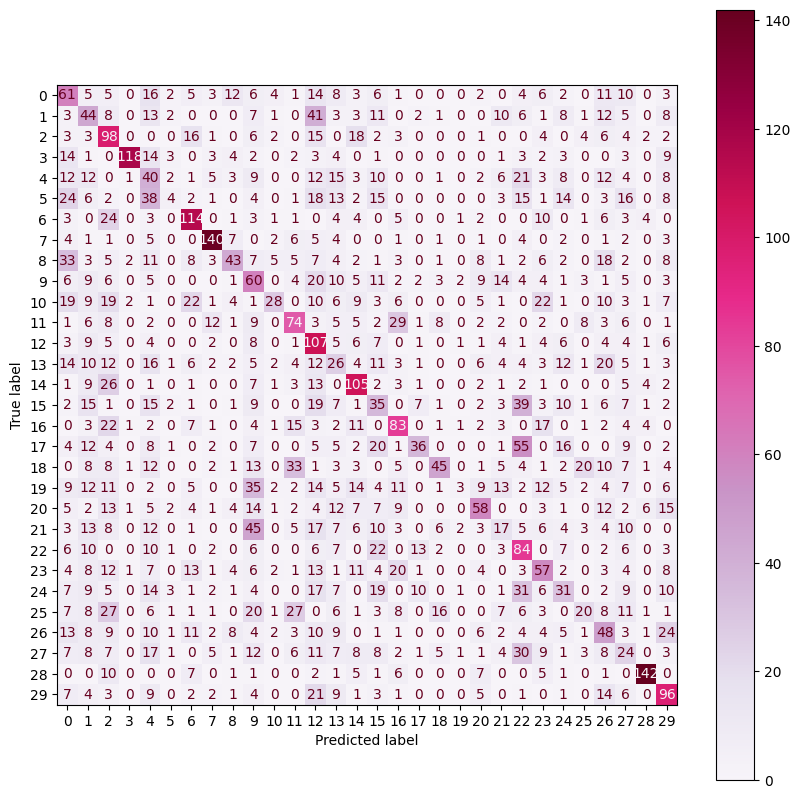

In [84]:
cm = confusion_matrix(y_test_or, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(cmap="PuRd", ax=ax)

### 8 categories


In [34]:
def init_model():
    model = Sequential()
    model.add(layers.Masking())
    model.add(layers.LSTM(20, activation='tanh'))
    #model.add(layers.Dropout(0.2))  
    #model.add(layers.LSTM(25, activation='tanh'))
    #model.add(layers.Dropout(0.2))  
    model.add(layers.Dense(15, activation='relu')) #, kernel_regularizer=l2(0.01)
    model.add(layers.Dense(8, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    
    return model

model = init_model()

In [35]:
es = EarlyStopping(patience=10, restore_best_weights=True, monitor='val_accuracy')

history = model.fit(X_train_pad, y_train_umbr, 
          batch_size = 16,
          epochs=100,
          validation_split=0.2,
          callbacks=[es]
         )

Epoch 1/100
2565/2565 [==============================] - 32s 12ms/step - loss: 1.6140 - accuracy: 0.4073 - val_loss: 1.5523 - val_accuracy: 0.4764
Epoch 2/100
2565/2565 [==============================] - 28s 11ms/step - loss: 1.4782 - accuracy: 0.4679 - val_loss: 1.5426 - val_accuracy: 0.4768
Epoch 3/100
2565/2565 [==============================] - 27s 11ms/step - loss: 1.4393 - accuracy: 0.4813 - val_loss: 1.4595 - val_accuracy: 0.5173
Epoch 4/100
2565/2565 [==============================] - 27s 10ms/step - loss: 1.4143 - accuracy: 0.4907 - val_loss: 1.4335 - val_accuracy: 0.5098
Epoch 5/100
2565/2565 [==============================] - 26s 10ms/step - loss: 1.3968 - accuracy: 0.4988 - val_loss: 1.4873 - val_accuracy: 0.4808
Epoch 6/100
2565/2565 [==============================] - 26s 10ms/step - loss: 1.3829 - accuracy: 0.5029 - val_loss: 1.4620 - val_accuracy: 0.5223
Epoch 7/100
2565/2565 [==============================] - 27s 10ms/step - loss: 1.3732 - accuracy: 0.5056 - val_loss: 1

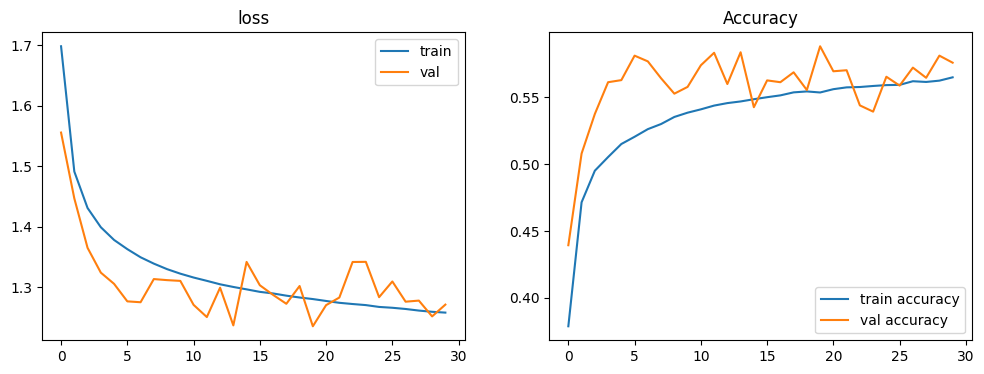

In [240]:
#plot_history(history); #first model learning curves (rmsprop, batch 32, val split 0.1)

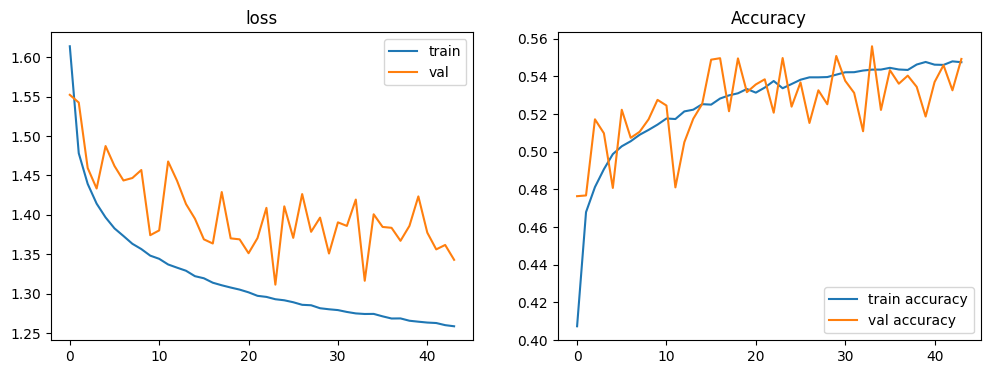

In [36]:
# plot history with adam, batch 16, valid.split 0.2 (no dropout or reguraliser)
plot_history(history); 

(<AxesSubplot:title={'center':'loss'}>,
 <AxesSubplot:title={'center':'Accuracy'}>)

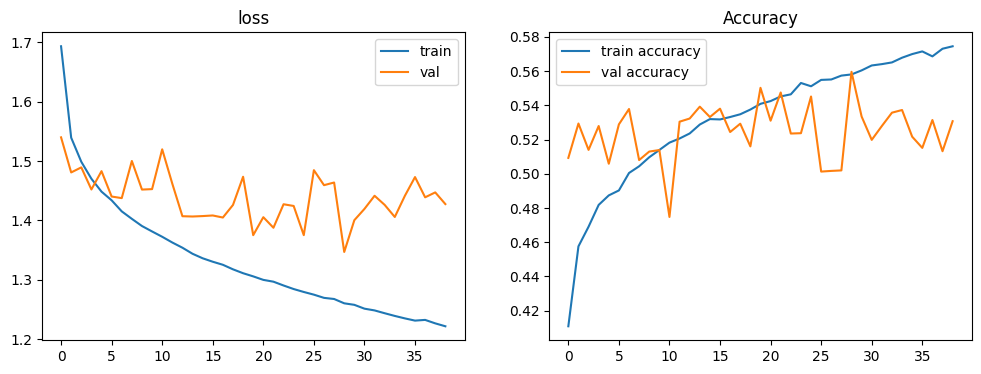

In [87]:
# plot history with adam, batch 32, val split 0.2, dropout layer, reguralisation and lstm 50
#plot_history(history)

(<AxesSubplot:title={'center':'loss'}>,
 <AxesSubplot:title={'center':'Accuracy'}>)

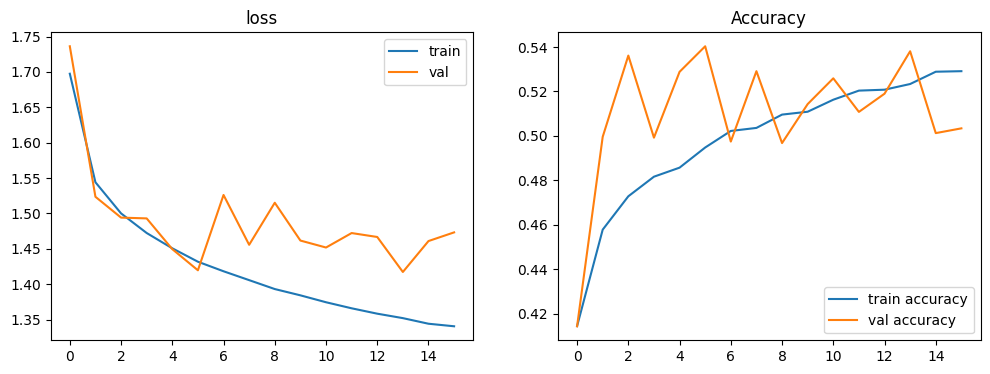

In [90]:
# same as above with rmsprop
plot_history(history)

In [37]:
res = model.evaluate(X_test_pad, y_test_umbr, verbose=0)

print(f'The accuracy evaluated on the test set is of {res[1]*100:.3f}%')

The accuracy evaluated on the test set is of 52.789%


In [41]:
y_pred_full = model.predict(X_test_pad)
y_pred = np.argmax(y_pred_full, axis=1)

179/179 [==============================] - 1s 4ms/step


In [48]:
print(y_pred_full[2])
print(y_pred[2])

[0.06055354 0.0807583  0.37854874 0.08262981 0.01942529 0.28143018
 0.01511656 0.0815376 ]
2


In [49]:
y_test_umbr_or = y_umbr_test_df['Genre_umbr_id'].astype(int)
y_test_umbr_or

0       2
1       7
2       0
3       0
4       6
       ..
5695    4
5696    4
5697    4
5698    4
5699    4
Name: Genre_umbr_id, Length: 5700, dtype: int64

In [50]:
top_k_accuracy = top_k_accuracy_score(y_test_umbr_or, y_pred_full, k=3)
print(f'Top 3 accuracy: {top_k_accuracy*100:.2f}%')

Top 3 accuracy: 25.51%


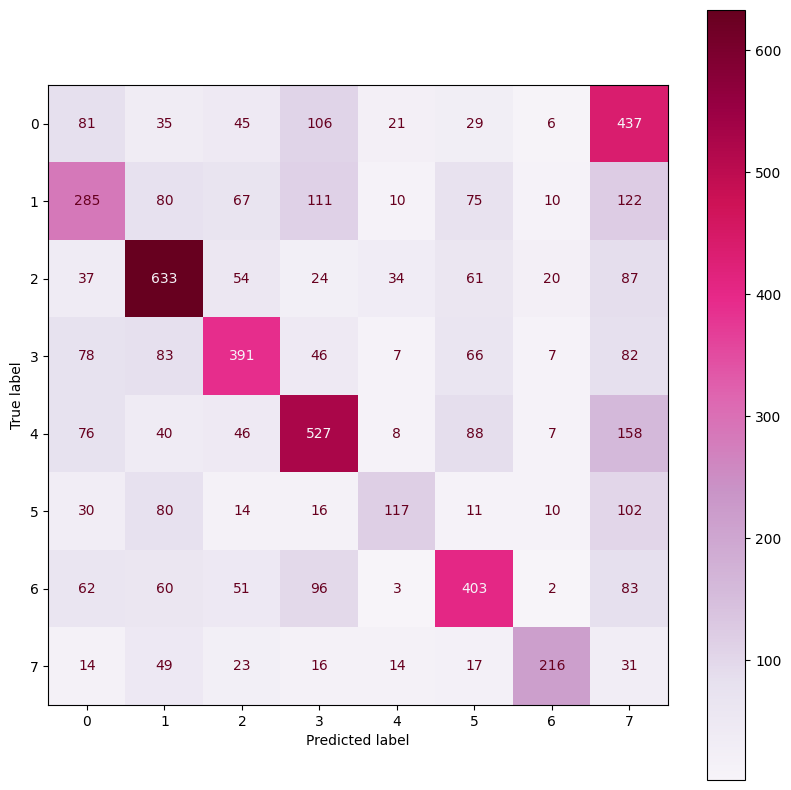

In [51]:
cm = confusion_matrix(y_test_umbr_or, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(cmap="PuRd", ax=ax)

## Model RNN (word2vec pre-trained)


In [15]:
# Load a Word2Vec embedding
word2vec_transfer = api.load("glove-wiki-gigaword-50")

# Function to convert a sentence (list of words) into a matrix representing the words in the embedding space
def embed_sentence_with_TF(word2vec, sentence):
    embedded_sentence = []
    for word in sentence:
        if word in word2vec:
            embedded_sentence.append(word2vec[word])
        
    return np.array(embedded_sentence)

# Function that converts a list of sentences into a list of matrices
def embedding(word2vec, sentences):
    embed = []
    
    for sentence in sentences:
        embedded_sentence = embed_sentence_with_TF(word2vec, sentence)
        embed.append(embedded_sentence)
        
    return embed


In [16]:
# Embed the training and test sentences
X_train_embed = embedding(word2vec_transfer, X_train_preproc)
X_test_embed = embedding(word2vec_transfer, X_test_preproc)

In [17]:
# Pad the training and test embedded sentences
X_train_pad = pad_sequences(X_train_embed, dtype='float32', padding='post', maxlen=100)
X_test_pad = pad_sequences(X_test_embed, dtype='float32', padding='post', maxlen=100)

### 30 categories


In [29]:
X_train_pad.shape

(51300, 100, 50)

In [77]:
def init_model():
    model = Sequential()
    model.add(layers.Masking())
    model.add(layers.LSTM(20, activation='tanh'))
    model.add(layers.Dense(15, activation='relu'))
    model.add(layers.Dense(30, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])
    
    return model

model = init_model()

In [78]:
es = EarlyStopping(patience=10, restore_best_weights=True, monitor='val_accuracy')

history = model.fit(X_train_pad, y_train, 
          batch_size = 32,
          epochs=100,
          validation_split=0.1,
          callbacks=[es]
         )

Epoch 1/100
1443/1443 [==============================] - 30s 19ms/step - loss: 3.0601 - accuracy: 0.1341 - val_loss: 3.0279 - val_accuracy: 0.1526
Epoch 2/100
1443/1443 [==============================] - 25s 17ms/step - loss: 2.6505 - accuracy: 0.2450 - val_loss: 2.7825 - val_accuracy: 0.2047
Epoch 3/100
1443/1443 [==============================] - 25s 17ms/step - loss: 2.5160 - accuracy: 0.2840 - val_loss: 2.5847 - val_accuracy: 0.2639
Epoch 4/100
1443/1443 [==============================] - 25s 17ms/step - loss: 2.4461 - accuracy: 0.3034 - val_loss: 2.5328 - val_accuracy: 0.2885
Epoch 5/100
1443/1443 [==============================] - 25s 17ms/step - loss: 2.4018 - accuracy: 0.3182 - val_loss: 2.5313 - val_accuracy: 0.2936
Epoch 6/100
1443/1443 [==============================] - 25s 17ms/step - loss: 2.3671 - accuracy: 0.3317 - val_loss: 2.5025 - val_accuracy: 0.2982
Epoch 7/100
1443/1443 [==============================] - 25s 17ms/step - loss: 2.3411 - accuracy: 0.3393 - val_loss: 2

(<AxesSubplot:title={'center':'loss'}>,
 <AxesSubplot:title={'center':'Accuracy'}>)

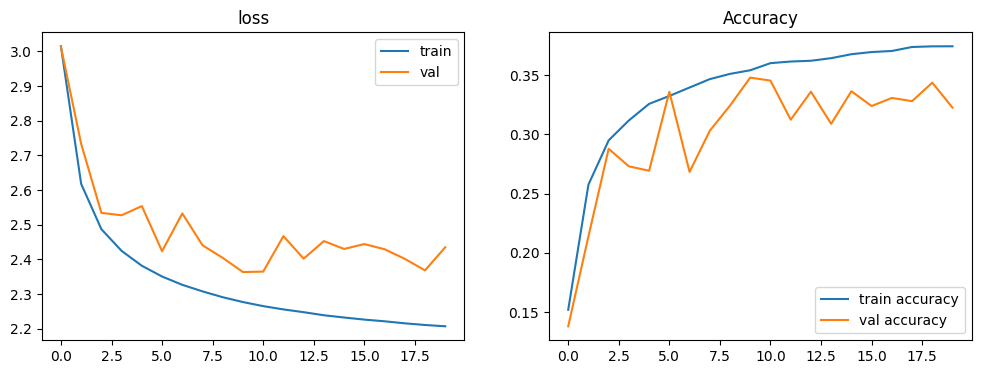

In [215]:
#plot_history(history) # plot history with rmsprop, batch 32, val split 0.1

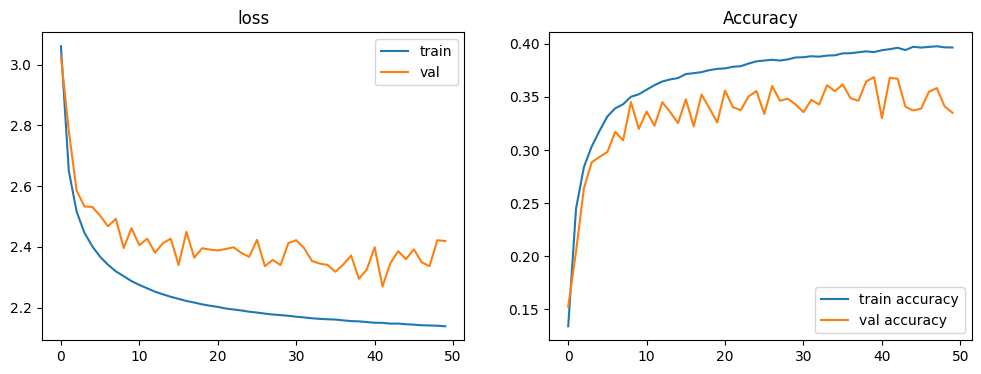

In [79]:
# exact same as above
plot_history(history);

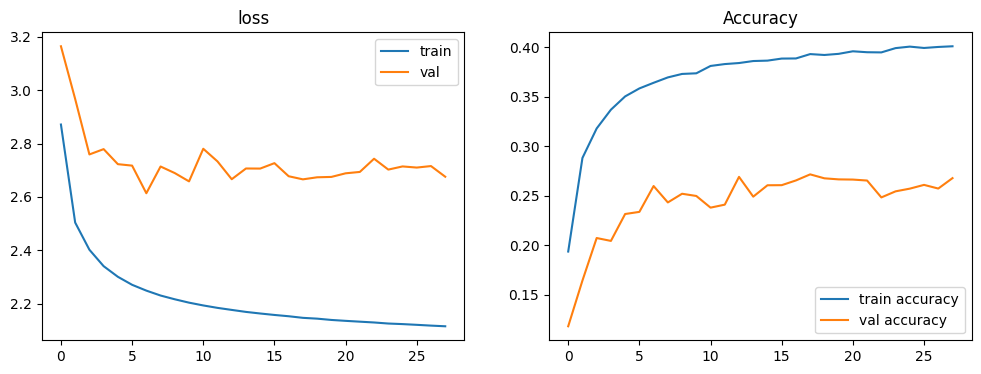

In [58]:
# plot history with adam, batch 16, val split 0.2
#plot_history(history);

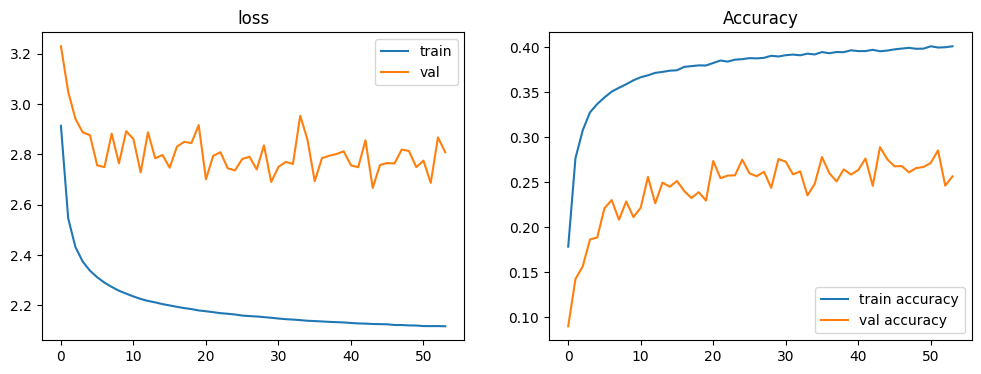

In [62]:
# plot history with rmsprop, batch 16, val split 0.2
#plot_history(history);

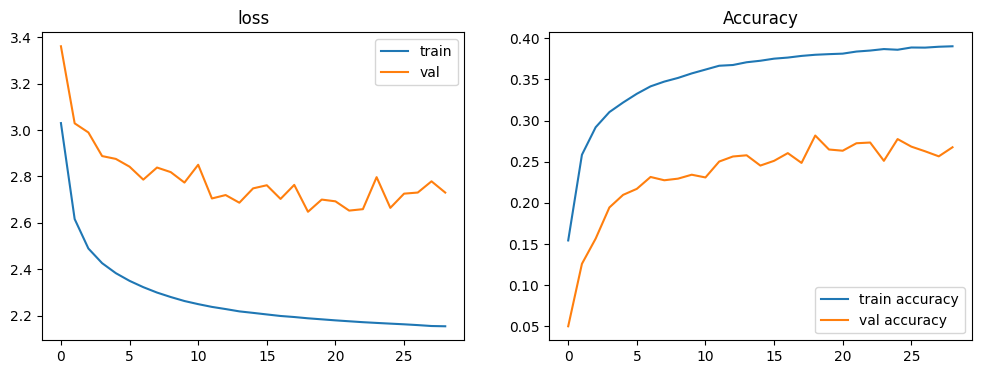

In [70]:
# plot history with rmsprop, batch 32, val split 0.2
plot_history(history);

In [80]:
res = model.evaluate(X_test_pad, y_test, verbose=0)

print(f'The accuracy evaluated on the test set is of {res[1]*100:.3f}%')

The accuracy evaluated on the test set is of 33.667%


In [81]:
y_pred_full = model.predict(X_test_pad)
y_pred = np.argmax(y_pred_full, axis=1)

179/179 [==============================] - 1s 4ms/step


In [83]:
y_test_or = pd.read_csv("../raw_data/test_y.csv", delimiter=" ", index_col="Id")['Genre_id']
y_test_or

Id
0       16
1       28
2        1
3       21
4        0
        ..
5695    17
5696    17
5697    17
5698    17
5699    17
Name: Genre_id, Length: 5700, dtype: int64

In [84]:
top_k_accuracy = top_k_accuracy_score(y_test_or, y_pred_full, k=3)
print(f'Top 3 accuracy: {top_k_accuracy*100:.2f}%')

Top 3 accuracy: 55.91%


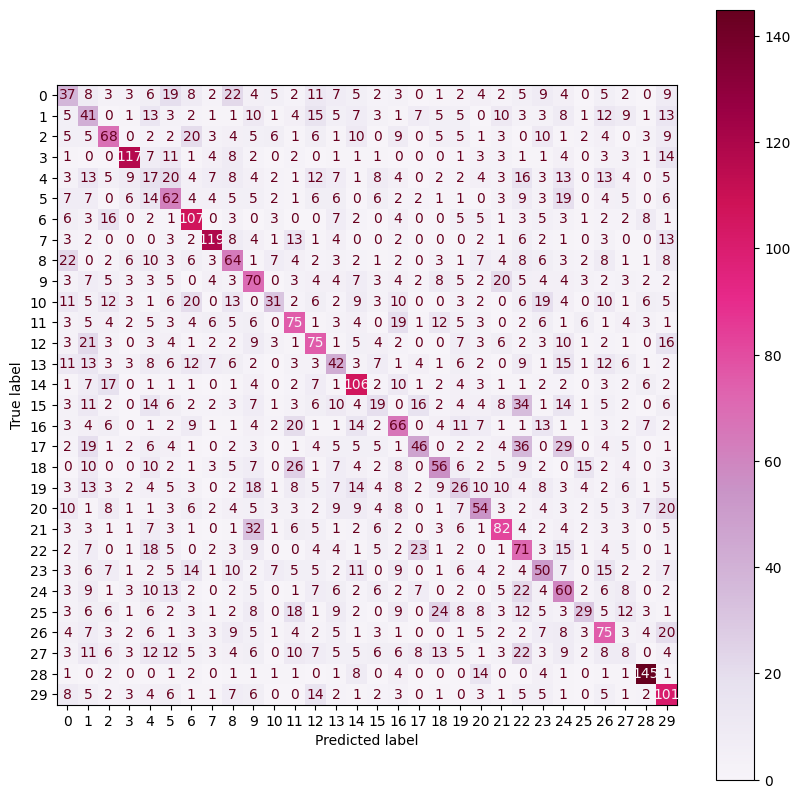

In [85]:
cm = confusion_matrix(y_test_or, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(cmap="PuRd", ax=ax)

### 8 categories

In [86]:
def init_model():
    model = Sequential()
    model.add(layers.Masking())
    model.add(layers.LSTM(20, activation='tanh'))
    model.add(layers.Dense(15, activation='relu'))
    model.add(layers.Dense(8, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])
    
    return model

model = init_model()

In [87]:
es = EarlyStopping(patience=10, restore_best_weights=True, monitor='val_accuracy')

history = model.fit(X_train_pad, y_train_umbr, 
          batch_size = 32,
          epochs=100,
          validation_split=0.1,
          callbacks=[es]
         )


Epoch 1/100
1443/1443 [==============================] - 30s 19ms/step - loss: 1.7155 - accuracy: 0.3790 - val_loss: 1.5353 - val_accuracy: 0.4647
Epoch 2/100
1443/1443 [==============================] - 26s 18ms/step - loss: 1.4943 - accuracy: 0.4736 - val_loss: 1.4209 - val_accuracy: 0.5090
Epoch 3/100
1443/1443 [==============================] - 25s 18ms/step - loss: 1.4320 - accuracy: 0.4964 - val_loss: 1.3590 - val_accuracy: 0.5324
Epoch 4/100
1443/1443 [==============================] - 25s 18ms/step - loss: 1.3983 - accuracy: 0.5080 - val_loss: 1.3346 - val_accuracy: 0.5425
Epoch 5/100
1443/1443 [==============================] - 26s 18ms/step - loss: 1.3753 - accuracy: 0.5186 - val_loss: 1.3053 - val_accuracy: 0.5540
Epoch 6/100
1443/1443 [==============================] - 26s 18ms/step - loss: 1.3580 - accuracy: 0.5230 - val_loss: 1.2875 - val_accuracy: 0.5665
Epoch 7/100
1443/1443 [==============================] - 26s 18ms/step - loss: 1.3456 - accuracy: 0.5288 - val_loss: 1

In [88]:
y_test_umbr_or

0       2
1       7
2       0
3       0
4       6
       ..
5695    4
5696    4
5697    4
5698    4
5699    4
Name: Genre_umbr_id, Length: 5700, dtype: int64

(<AxesSubplot:title={'center':'loss'}>,
 <AxesSubplot:title={'center':'Accuracy'}>)

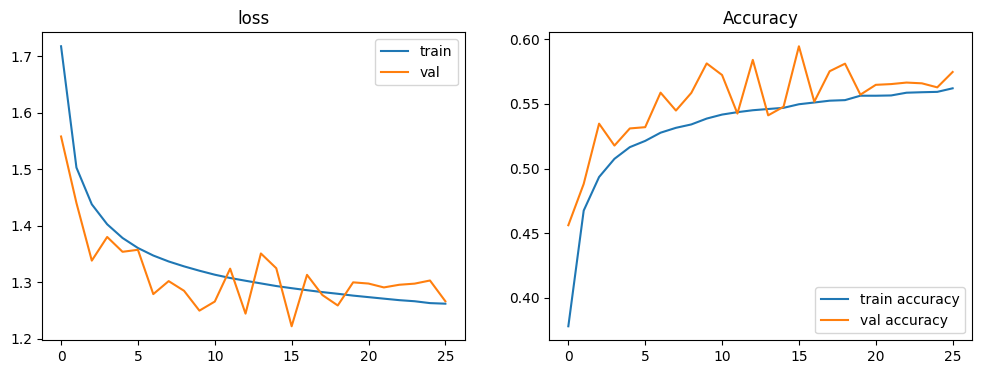

In [255]:
plot_history(history)

(<AxesSubplot:title={'center':'loss'}>,
 <AxesSubplot:title={'center':'Accuracy'}>)

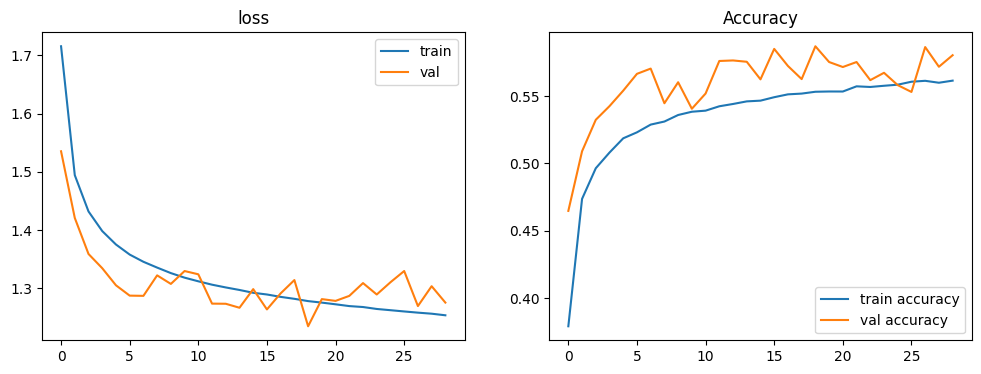

In [90]:
# same as above model
plot_history(history)

In [91]:
res = model.evaluate(X_test_pad, y_test_umbr, verbose=0)

print(f'The accuracy evaluated on the test set is of {res[1]*100:.3f}%')

The accuracy evaluated on the test set is of 52.053%


In [92]:
y_pred_full = model.predict(X_test_pad)
y_pred = np.argmax(y_pred_full, axis=1)

179/179 [==============================] - 1s 4ms/step


In [93]:
top_k_accuracy = top_k_accuracy_score(y_test_umbr_or, y_pred_full, k=3)
print(f'Top 3 accuracy: {top_k_accuracy*100:.2f}%')

Top 3 accuracy: 26.11%


0       2
1       7
2       0
3       0
4       6
       ..
5695    4
5696    4
5697    4
5698    4
5699    4
Name: Genre_umbr_id, Length: 5700, dtype: int64

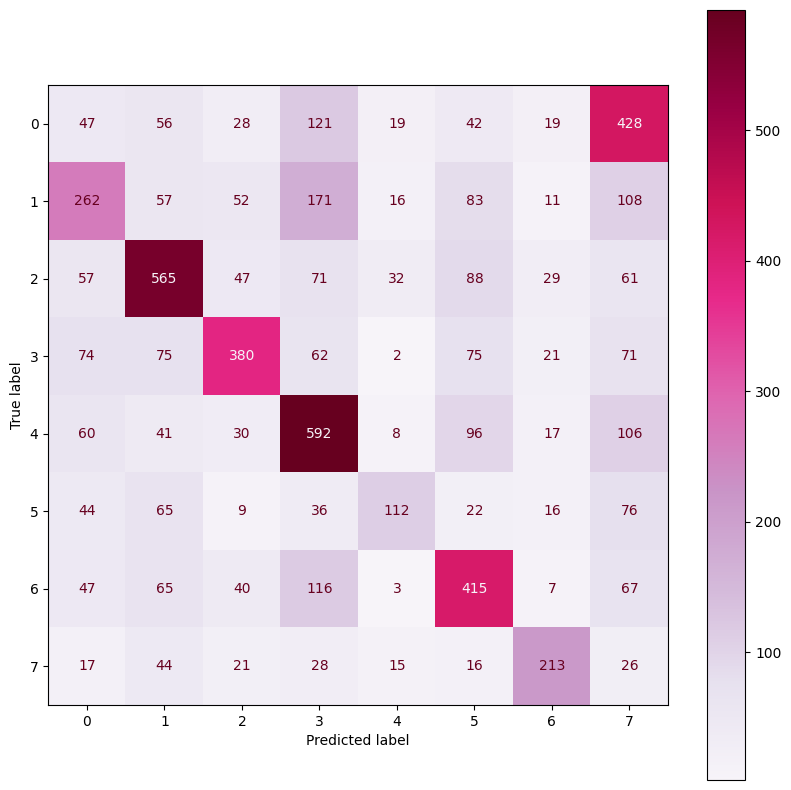

In [94]:
cm = confusion_matrix(y_test_umbr_or, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(cmap="PuRd", ax=ax)

## Integrating Embedding + Extracted Features

### Combined dataset

In [38]:
X_train_pad2.shape, X_test_pad2.shape

((51300, 100, 50), (5700, 100, 50))

In [31]:
X_test_pad

array([[[ 0.66622  , -0.22861  , -0.42213  , ...,  0.5107   ,
          0.2347   ,  0.50334  ],
        [-0.16811  , -0.054811 ,  1.3435   , ..., -0.35313  ,
          1.3851   ,  1.4179   ],
        [ 0.21541  ,  0.20709  , -1.7487   , ...,  0.65252  ,
         -1.1549   , -0.081047 ],
        ...,
        [ 0.       ,  0.       ,  0.       , ...,  0.       ,
          0.       ,  0.       ],
        [ 0.       ,  0.       ,  0.       , ...,  0.       ,
          0.       ,  0.       ],
        [ 0.       ,  0.       ,  0.       , ...,  0.       ,
          0.       ,  0.       ]],

       [[-0.4434   ,  0.15597  ,  0.22602  , ..., -0.42408  ,
          0.24134  ,  0.77441  ],
        [-0.1567   ,  0.26117  ,  0.78881  , ..., -0.11134  ,
          0.2709   , -0.48713  ],
        [ 0.13175  , -0.25517  , -0.067915 , ...,  0.97798  ,
          0.58507  , -0.30176  ],
        ...,
        [ 0.       ,  0.       ,  0.       , ...,  0.       ,
          0.       ,  0.       ],
        [ 0.

In [39]:
X_train_picture_features = pd.read_csv('../raw_data/extracted_features/X_train_picture_features_pp.csv')
X_test_picture_features = pd.read_csv('../raw_data/extracted_features/X_test_picture_features_pp.csv')

### x_test integration

In [40]:
X_test_picture_features = X_test_picture_features.iloc[:,1:]
X_test_picture_features

,brightness,nb_colors,hue_1,lightness_1,saturation_1,face_detected
0,0.480159,0.403702,0.676880,0.529,0.242,0
1,0.742063,0.486117,0.119777,0.833,0.176,1
2,0.456349,0.256066,0.055710,0.343,0.017,0
3,0.813492,0.516666,0.231198,0.767,0.445,0
4,0.650794,0.430810,0.479109,0.725,0.057,0
...,...,...,...,...,...,...
5695,0.496032,0.833337,0.434540,0.249,0.102,0
5696,0.817460,0.355466,0.518106,0.831,0.674,0
5697,0.634921,0.762920,0.130919,0.594,0.469,0
5698,0.619048,0.214240,0.094708,0.757,0.097,0


In [41]:
X_test_picture_features_ext = pd.concat([X_test_picture_features, df_test[['commas', 'special_chars']]], axis=1) 

In [42]:
X_test_picture_features_ext

,brightness,nb_colors,hue_1,lightness_1,saturation_1,face_detected,commas,special_chars
0,0.480159,0.403702,0.676880,0.529,0.242,0,0,1
1,0.742063,0.486117,0.119777,0.833,0.176,1,0,1
2,0.456349,0.256066,0.055710,0.343,0.017,0,0,0
3,0.813492,0.516666,0.231198,0.767,0.445,0,1,0
4,0.650794,0.430810,0.479109,0.725,0.057,0,0,0
...,...,...,...,...,...,...,...,...
5695,0.496032,0.833337,0.434540,0.249,0.102,0,0,0
5696,0.817460,0.355466,0.518106,0.831,0.674,0,0,0
5697,0.634921,0.762920,0.130919,0.594,0.469,0,0,1
5698,0.619048,0.214240,0.094708,0.757,0.097,0,0,1


In [43]:
X_test_picture_features_array = X_test_picture_features_ext.to_numpy()

In [36]:
# Expand dimensions of X_test_picture_features_array to match the length of 100
X_test_picture_features_expanded = np.expand_dims(X_test_picture_features_array, axis=1)
X_test_picture_features_repeated = np.repeat(X_test_picture_features_expanded, 100, axis=1)

X_test_picture_features_repeated.shape

X_test_combined = np.concatenate((X_test_pad, X_test_picture_features_repeated), axis=2)

pd.DataFrame(np.reshape(X_test_combined, (5700,5800)))

### x_train integration

In [44]:
X_train_picture_features = X_train_picture_features.iloc[:,1:]
X_train_picture_features

,brightness,nb_colors,hue_1,lightness_1,saturation_1,face_detected
0,0.619048,0.163324,0.189415,0.335,0.123,0
1,0.623016,0.420544,0.554318,0.620,0.495,0
2,0.257937,0.097421,0.000000,0.288,0.932,0
3,0.765873,0.574715,0.181058,0.775,0.652,0
4,0.547619,0.538826,0.604457,0.596,0.359,0
...,...,...,...,...,...,...
51295,0.523810,0.710911,0.047354,0.490,0.448,0
51296,0.444444,0.349900,0.674095,0.184,0.234,0
51297,0.369048,0.315743,0.649025,0.153,0.128,0
51298,0.388889,0.277112,0.036212,0.292,0.181,1


In [45]:
X_train_picture_features.shape

(51300, 6)

In [46]:
X_train_picture_features_ext = pd.concat([X_train_picture_features, df_train[['commas', 'special_chars']]], axis=1) 

In [47]:
X_train_picture_features_ext

,brightness,nb_colors,hue_1,lightness_1,saturation_1,face_detected,commas,special_chars
0,0.619048,0.163324,0.189415,0.335,0.123,0,1,1
1,0.623016,0.420544,0.554318,0.620,0.495,0,0,0
2,0.257937,0.097421,0.000000,0.288,0.932,0,0,0
3,0.765873,0.574715,0.181058,0.775,0.652,0,0,1
4,0.547619,0.538826,0.604457,0.596,0.359,0,0,0
...,...,...,...,...,...,...,...,...
51295,0.523810,0.710911,0.047354,0.490,0.448,0,0,1
51296,0.444444,0.349900,0.674095,0.184,0.234,0,0,0
51297,0.369048,0.315743,0.649025,0.153,0.128,0,0,0
51298,0.388889,0.277112,0.036212,0.292,0.181,1,0,0


In [48]:
X_train_picture_features_array = X_train_picture_features_ext.to_numpy()

In [44]:
X_train_picture_features_expanded = np.expand_dims(X_train_picture_features_array, axis=1)
X_train_picture_features_repeated = np.repeat(X_train_picture_features_expanded, 100, axis=1)

X_train_combined = np.concatenate((X_train_pad, X_train_picture_features_repeated), axis=2)
X_train_combined.shape, y_train.shape

### Model (Word2Vec pretrained, 30 cat) - weird curves ones


In [46]:
X_test_combined.shape

(5700, 100, 58)

In [94]:
def init_model():
    model = Sequential()
    model.add(layers.Masking())
    model.add(layers.LSTM(20, activation='tanh'))
    model.add(layers.Dense(15, activation='relu'))
    model.add(layers.Dense(30, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])
    
    return model

model = init_model()

In [95]:
es = EarlyStopping(patience=10, restore_best_weights=True, monitor='val_accuracy')

history = model.fit(X_train_combined, y_train, 
          batch_size = 32,
          epochs=100,
          validation_split=0.1,
          callbacks=[es]
         )

Epoch 1/100
1443/1443 [==============================] - 29s 18ms/step - loss: 3.3024 - accuracy: 0.0638 - val_loss: 3.5670 - val_accuracy: 0.0136
Epoch 2/100
1443/1443 [==============================] - 25s 18ms/step - loss: 3.2136 - accuracy: 0.0851 - val_loss: 3.5502 - val_accuracy: 0.0092
Epoch 3/100
1443/1443 [==============================] - 29s 20ms/step - loss: 3.1942 - accuracy: 0.0906 - val_loss: 3.5241 - val_accuracy: 0.0152
Epoch 4/100
1443/1443 [==============================] - 29s 20ms/step - loss: 3.1656 - accuracy: 0.0945 - val_loss: 3.5016 - val_accuracy: 0.0064
Epoch 5/100
1443/1443 [==============================] - 28s 19ms/step - loss: 3.1324 - accuracy: 0.1012 - val_loss: 3.4236 - val_accuracy: 0.0587
Epoch 6/100
1443/1443 [==============================] - 26s 18ms/step - loss: 3.1269 - accuracy: 0.1019 - val_loss: 3.4075 - val_accuracy: 0.0558
Epoch 7/100
1443/1443 [==============================] - 27s 19ms/step - loss: 3.1237 - accuracy: 0.1061 - val_loss: 3

In [ ]:
X_train_pad.shape

(<AxesSubplot:title={'center':'loss'}>,
 <AxesSubplot:title={'center':'Accuracy'}>)

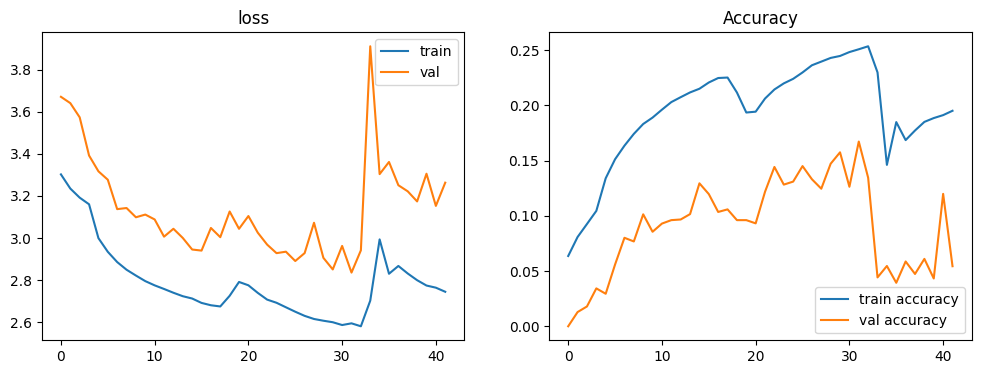

In [163]:
#plot_history(history) # lstm 56, rmsprop, batch 32, valsplit 0.1

(<AxesSubplot:title={'center':'loss'}>,
 <AxesSubplot:title={'center':'Accuracy'}>)

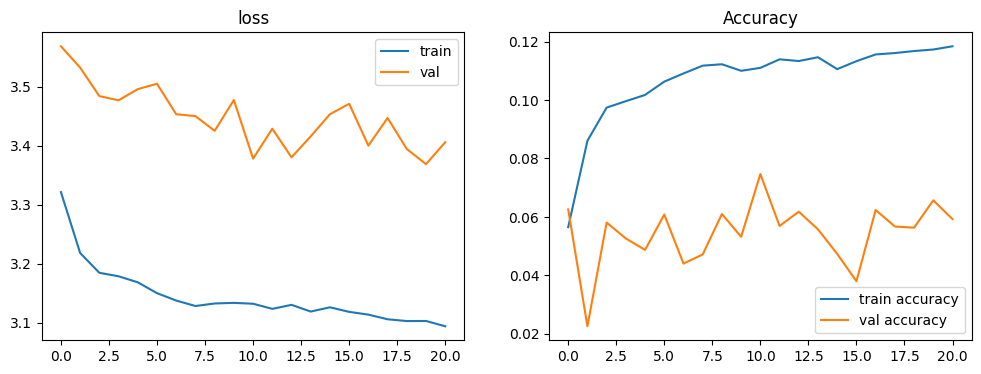

In [69]:
plot_history(history) # lstm 20, rmsprop, batch 32, valsplit 0.1 + commas and special characters

(<AxesSubplot:title={'center':'loss'}>,
 <AxesSubplot:title={'center':'Accuracy'}>)

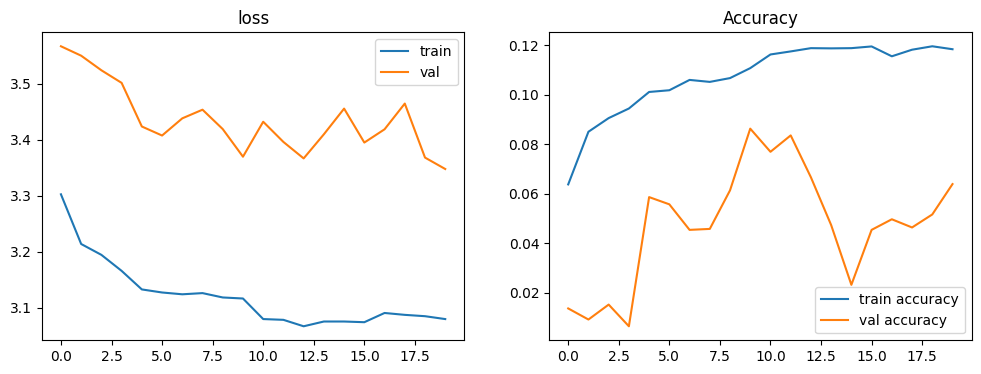

In [97]:
plot_history(history) # lstm 20, rmsprop, batch 32, valsplit 0.1 no commas no special characters

In [98]:
res = model.evaluate(X_test_combined, y_test, verbose=0)
print(f'The accuracy evaluated on the test set is of {res[1]*100:.3f}%')

The accuracy evaluated on the test set is of 11.088%


## Stack overflow model (using Keras functional API instead of Sequential)

In [43]:
X_train_picture_features_array.shape, X_test_picture_features_array.shape

((51300, 8), (5700, 8))

In [44]:
X_train_pad.shape, X_train_picture_features_array.shape

((51300, 100, 50), (51300, 8))

In [46]:
X_train_punct = X_train_picture_features_ext.iloc[:,6:].to_numpy()
X_test_punct = X_test_picture_features_ext.iloc[:,6:].to_numpy()

In [47]:
X_train_punct.shape, X_test_punct.shape

((51300, 2), (5700, 2))

In [75]:
def init_model():
    # Input layers
    input_1 = Input(shape=(100,50)) # embeddings input shape
    input_2 = Input(shape=(8,)) # nahia features input shape
    
    # Masking layer
    masked = Masking()(input_1)
    
    # LSTM
    lstm = LSTM(20, activation='tanh')(masked)
    
    # Concatenate LSTM output with additional input
    concatenated = Concatenate()([lstm, input_2])
    
    # dense layers
    dense1 = Dense(15, activation='relu')(concatenated)
    dense2 = Dense(30, activation='softmax')(dense1)
    
    # Create model
    model = Model(inputs=[input_1, input_2], outputs=dense2)
    
    # Compile model
    model.compile(loss='categorical_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])
    
    return model

model = init_model()    

In [76]:
es = EarlyStopping(patience=10, restore_best_weights=True, monitor='val_accuracy')

history = model.fit([X_train_pad, X_train_picture_features_array], y_train, 
          batch_size = 32,
          epochs=100,
          validation_split=0.1,
          callbacks=[es]
         )

Epoch 1/100
1443/1443 [==============================] - 28s 18ms/step - loss: 3.0490 - accuracy: 0.1495 - val_loss: 2.9609 - val_accuracy: 0.1587
Epoch 2/100
1443/1443 [==============================] - 25s 18ms/step - loss: 2.6085 - accuracy: 0.2578 - val_loss: 2.6831 - val_accuracy: 0.2211
Epoch 3/100
1443/1443 [==============================] - 28s 19ms/step - loss: 2.4540 - accuracy: 0.3006 - val_loss: 2.5718 - val_accuracy: 0.2710
Epoch 4/100
1443/1443 [==============================] - 26s 18ms/step - loss: 2.3781 - accuracy: 0.3214 - val_loss: 2.4612 - val_accuracy: 0.3031
Epoch 5/100
1443/1443 [==============================] - 27s 19ms/step - loss: 2.3305 - accuracy: 0.3353 - val_loss: 2.4789 - val_accuracy: 0.2955
Epoch 6/100
1443/1443 [==============================] - 24s 16ms/step - loss: 2.2976 - accuracy: 0.3461 - val_loss: 2.4718 - val_accuracy: 0.2951
Epoch 7/100
1443/1443 [==============================] - 24s 16ms/step - loss: 2.2740 - accuracy: 0.3536 - val_loss: 2

(<AxesSubplot:title={'center':'loss'}>,
 <AxesSubplot:title={'center':'Accuracy'}>)

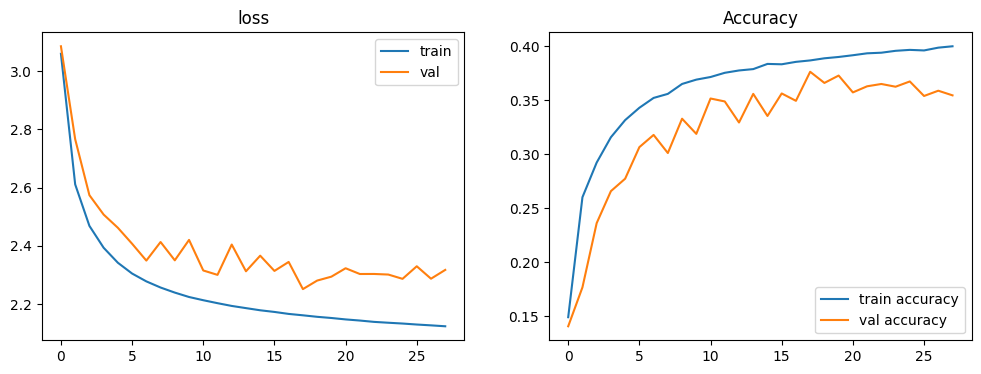

In [55]:
# plot_history(history) # with image features + punctuation

In [56]:
# with image features + punctuation
#res = model.evaluate([X_test_pad, X_test_picture_features_array], y_test, verbose=0)
#print(f'The accuracy evaluated on the test set is of {res[1]*100:.3f}%')

The accuracy evaluated on the test set is of 34.175%


(<AxesSubplot:title={'center':'loss'}>,
 <AxesSubplot:title={'center':'Accuracy'}>)

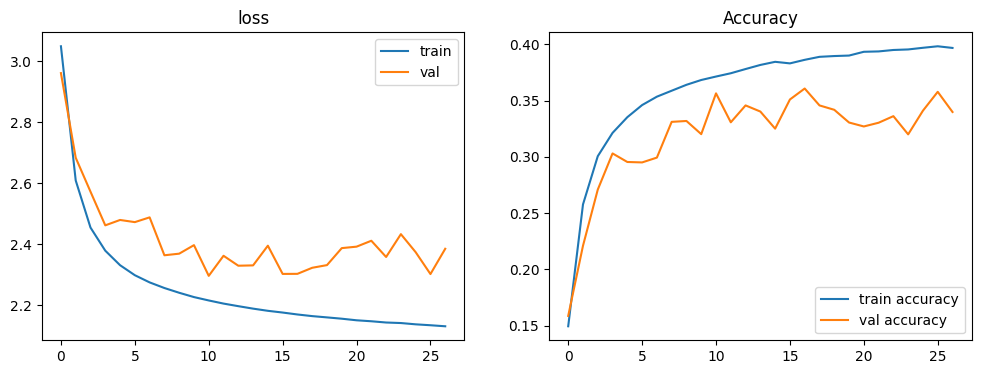

In [77]:
plot_history(history) # same as above -test

(<AxesSubplot:title={'center':'loss'}>,
 <AxesSubplot:title={'center':'Accuracy'}>)

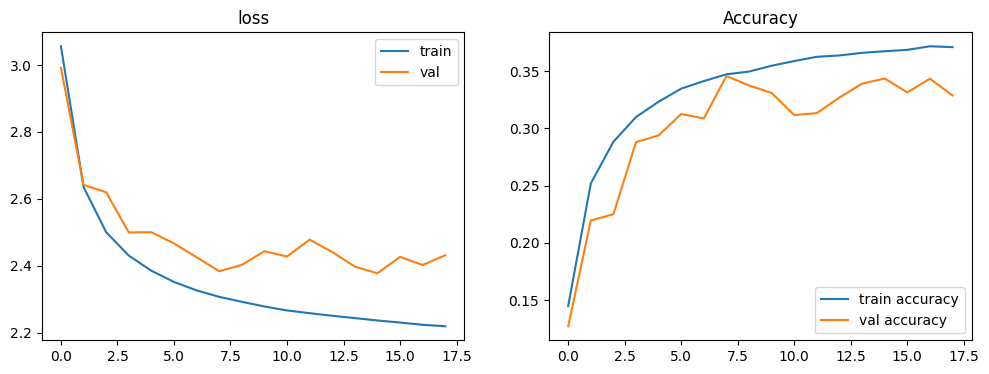

In [65]:
#plot_history(history) # punctuation only

In [79]:
# punctuation only
res = model.evaluate([X_test_pad, X_test_picture_features_array], y_test, verbose=0)
print(f'The accuracy evaluated on the test set is of {res[1]*100:.3f}%')

The accuracy evaluated on the test set is of 34.842%


In [81]:

y_pred_full = model.predict([X_test_pad, X_test_picture_features_array])
y_pred = np.argmax(y_pred_full, axis=1)

179/179 [==============================] - 2s 6ms/step


In [82]:
print(y_pred_full[0])
print(y_pred[0])
print(y_test_or[0])

[9.7363262e-04 2.7473152e-04 3.7759433e-03 2.1561723e-06 5.0576666e-04
 1.8724479e-05 8.1360182e-03 5.9444475e-04 4.5900997e-03 3.3739179e-03
 5.3033540e-03 1.4814742e-01 1.9834799e-04 1.8765078e-03 7.2047310e-03
 4.1216449e-04 6.7164576e-01 3.2407843e-05 5.2313209e-03 1.3890025e-02
 5.1069804e-03 3.4164703e-03 1.2725932e-04 9.2261806e-02 3.6495123e-05
 1.3226101e-02 7.9854846e-04 3.3227254e-03 5.2459091e-03 2.7028090e-04]
16
16


In [83]:
y_test_or = pd.read_csv("../raw_data/test_y.csv", delimiter=" ", index_col="Id")['Genre_id']
y_test_or

Id
0       16
1       28
2        1
3       21
4        0
        ..
5695    17
5696    17
5697    17
5698    17
5699    17
Name: Genre_id, Length: 5700, dtype: int64

In [84]:
top_k_accuracy = top_k_accuracy_score(y_test_or, y_pred_full, k=3)
print(f'Top 3 accuracy: {top_k_accuracy*100:.2f}%')

Top 3 accuracy: 57.37%


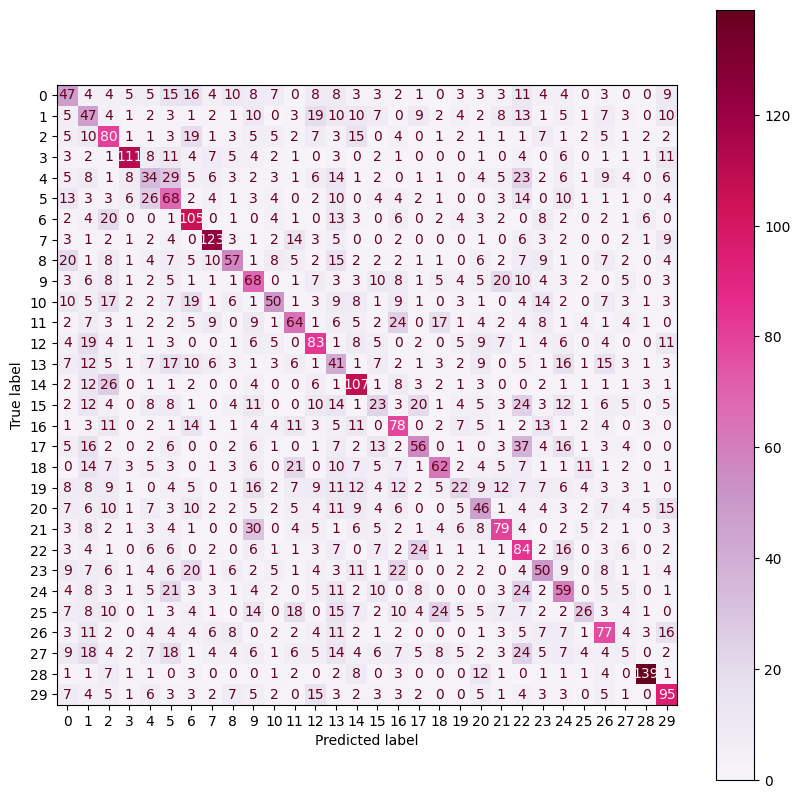

In [85]:
cm = confusion_matrix(y_test_or, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(cmap="PuRd", ax=ax)

## Stack overflow + Daniel model

### version 1

In [48]:
def init_model():
    # Input layers
    input_1 = Input(shape=(100,50)) # embeddings input shape
    input_2 = Input(shape=(8,)) # nahia features input shape
    
    # Masking layer
    masked = Masking()(input_1)
    
    # LSTM
    lstm = LSTM(50, activation='tanh', dropout=0.2, recurrent_dropout=0.2)(masked)
    
    # Concatenate LSTM output with additional input
    concatenated = Concatenate()([lstm, input_2])
    
    # dense layers
    dense1 = Dense(15, activation='relu')(concatenated) # next try removing this layer
    dense2 = Dense(30, activation='softmax')(dense1)
    
    # Create model
    model = Model(inputs=[input_1, input_2], outputs=dense2)
    
    # Compile model
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    
    return model

model = init_model()   

In [49]:
#es = EarlyStopping(patience=10, restore_best_weights=True, monitor='val_accuracy')
es = EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)

history = model.fit([X_train_pad, X_train_picture_features_array], y_train, 
          batch_size = 64,
          epochs=100,
          validation_split=0.1,
          callbacks=[es]
         )

Epoch 1/100
722/722 [==============================] - 47s 64ms/step - loss: 2.9384 - accuracy: 0.1857 - val_loss: 2.7325 - val_accuracy: 0.1875
Epoch 2/100
722/722 [==============================] - 46s 63ms/step - loss: 2.5416 - accuracy: 0.2827 - val_loss: 2.5172 - val_accuracy: 0.2756
Epoch 3/100
722/722 [==============================] - 46s 63ms/step - loss: 2.4403 - accuracy: 0.3095 - val_loss: 2.4679 - val_accuracy: 0.2949
Epoch 4/100
722/722 [==============================] - 45s 62ms/step - loss: 2.3776 - accuracy: 0.3265 - val_loss: 2.3845 - val_accuracy: 0.3097
Epoch 5/100
722/722 [==============================] - 45s 63ms/step - loss: 2.3325 - accuracy: 0.3391 - val_loss: 2.3031 - val_accuracy: 0.3265
Epoch 6/100
722/722 [==============================] - 44s 61ms/step - loss: 2.2972 - accuracy: 0.3512 - val_loss: 2.3381 - val_accuracy: 0.3320
Epoch 7/100
722/722 [==============================] - 45s 63ms/step - loss: 2.2720 - accuracy: 0.3535 - val_loss: 2.3914 - val_ac

(<AxesSubplot:title={'center':'loss'}>,
 <AxesSubplot:title={'center':'Accuracy'}>)

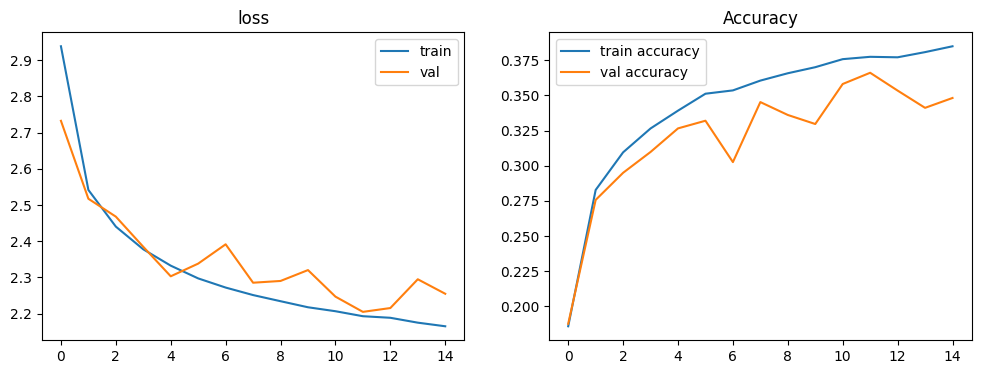

In [50]:
plot_history(history)

In [51]:
res = model.evaluate([X_test_pad, X_test_picture_features_array], y_test, verbose=0)
print(f'The accuracy evaluated on the test set is of {res[1]*100:.3f}%')

The accuracy evaluated on the test set is of 37.123%


In [52]:
y_pred_full = model.predict([X_test_pad, X_test_picture_features_array])
y_pred = np.argmax(y_pred_full, axis=1)

179/179 [==============================] - 2s 9ms/step


In [53]:
y_test_or = pd.read_csv("../raw_data/test_y.csv", delimiter=" ", index_col="Id")['Genre_id']

In [54]:
top_k_accuracy = top_k_accuracy_score(y_test_or, y_pred_full, k=3)
print(f'Top 3 accuracy: {top_k_accuracy*100:.2f}%')

Top 3 accuracy: 59.61%


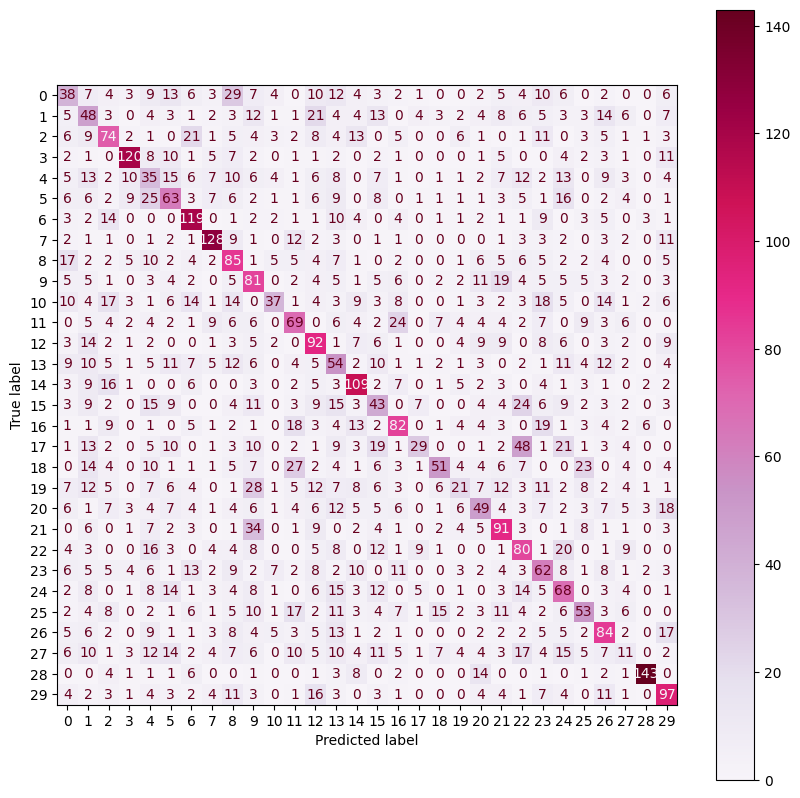

In [55]:
cm = confusion_matrix(y_test_or, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(cmap="PuRd", ax=ax)

# Winning model

### Old data (30 categories)

In [57]:
def init_model():
    # Input layers
    input_1 = Input(shape=(100,50)) # embeddings input shape
    input_2 = Input(shape=(8,)) # nahia features input shape
    
    # Masking layer
    masked = Masking()(input_1)
    
    # LSTM
    lstm = LSTM(50, activation='tanh', dropout=0.2, recurrent_dropout=0.2)(masked)
    
    # Concatenate LSTM output with additional input
    concatenated = Concatenate()([lstm, input_2])
    
    # dense layers
    dense2 = Dense(30, activation='softmax')(concatenated)
    
    # Create model
    model = Model(inputs=[input_1, input_2], outputs=dense2)
    
    # Compile model
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    
    return model

model = init_model()  

In [58]:
#es = EarlyStopping(patience=10, restore_best_weights=True, monitor='val_accuracy')
es = EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)

history = model.fit([X_train_pad, X_train_picture_features_array], y_train, 
          batch_size = 64,
          epochs=100,
          validation_split=0.1,
          callbacks=[es]
         )

Epoch 1/100
722/722 [==============================] - 47s 63ms/step - loss: 2.8429 - accuracy: 0.2078 - val_loss: 2.5979 - val_accuracy: 0.2571
Epoch 2/100
722/722 [==============================] - 44s 61ms/step - loss: 2.4948 - accuracy: 0.2999 - val_loss: 2.5090 - val_accuracy: 0.2899
Epoch 3/100
722/722 [==============================] - 45s 62ms/step - loss: 2.3949 - accuracy: 0.3253 - val_loss: 2.3610 - val_accuracy: 0.3370
Epoch 4/100
722/722 [==============================] - 44s 61ms/step - loss: 2.3317 - accuracy: 0.3422 - val_loss: 2.3762 - val_accuracy: 0.3236
Epoch 5/100
722/722 [==============================] - 44s 61ms/step - loss: 2.2901 - accuracy: 0.3528 - val_loss: 2.3455 - val_accuracy: 0.3407
Epoch 6/100
722/722 [==============================] - 44s 62ms/step - loss: 2.2581 - accuracy: 0.3623 - val_loss: 2.3348 - val_accuracy: 0.3446
Epoch 7/100
722/722 [==============================] - 43s 60ms/step - loss: 2.2315 - accuracy: 0.3695 - val_loss: 2.2534 - val_ac

(<AxesSubplot:title={'center':'loss'}>,
 <AxesSubplot:title={'center':'Accuracy'}>)

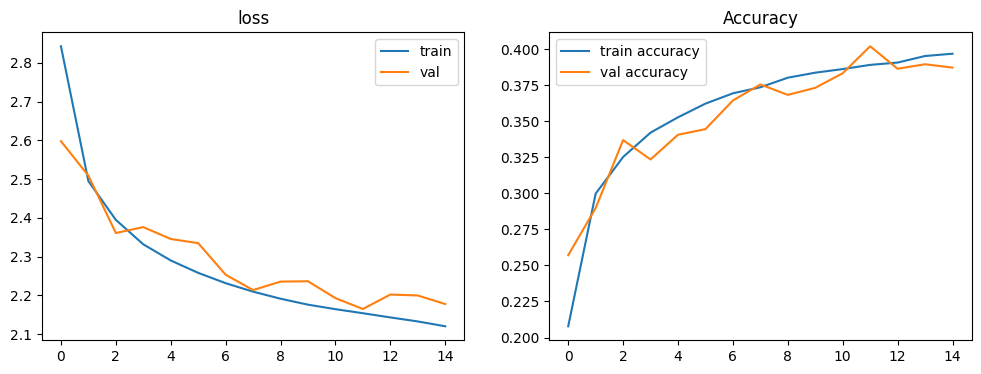

In [59]:
plot_history(history)

In [60]:
res = model.evaluate([X_test_pad, X_test_picture_features_array], y_test, verbose=0)
print(f'The accuracy evaluated on the test set is of {res[1]*100:.3f}%')

The accuracy evaluated on the test set is of 38.070%


In [61]:
y_pred_full = model.predict([X_test_pad, X_test_picture_features_array])
y_pred = np.argmax(y_pred_full, axis=1)

179/179 [==============================] - 2s 9ms/step


In [62]:
top_k_accuracy = top_k_accuracy_score(y_test_or, y_pred_full, k=3)
print(f'Top 3 accuracy: {top_k_accuracy*100:.2f}%')

Top 3 accuracy: 60.67%


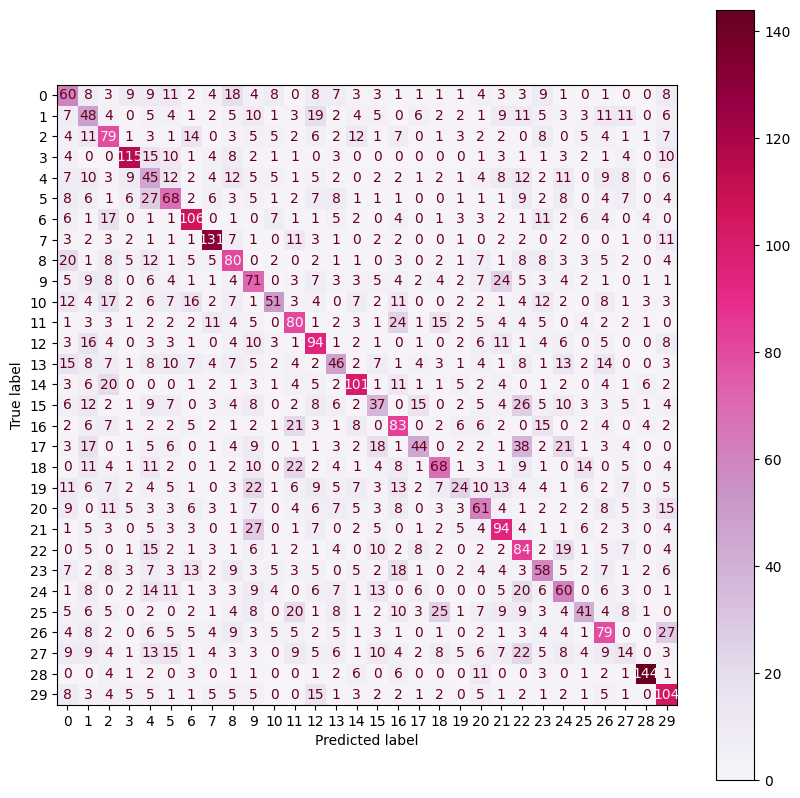

In [63]:
cm = confusion_matrix(y_test_or, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(cmap="PuRd", ax=ax)

## New data (X_fully_pp)

### 30 categories

In [21]:
df_test2 = pd.read_csv('../raw_data/titles_data/X_test_fully_pp.csv')
df_train2 = pd.read_csv('../raw_data/titles_data/X_train_fully_pp.csv')

In [22]:
df_train2

,Unnamed: 0,Image_name,Title,translated_title,preproc_title,spellchecked_title
0,0,1588345297.jpg,"Colet example, and SA sported ronals Gentl Twi...","Colet example, and SA sported ronals Gentl Twi...","['colet', 'example', 'and', 'sa', 'sported', '...",comet example and sa sported royals gentle twi...
1,1,1404803335.jpg,Maghets Pulling Together Pushing Apart,Maghets Pulling Together Pushing Apart,"['maghets', 'pulling', 'together', 'pushing', ...",magnets pulling together pushing apart
2,2,1446276082.jpg,ENERGY SECURITY VOLUME SAGE LIBRARY OF INTERNA...,ENERGY SECURITY VOLUME SAGE LIBRARY OF INTERNA...,"['energy', 'security', 'volume', 'sage', 'libr...",energy security volume sage library of interna...
3,3,1491522666.jpg,AUDIOBOOK MP3-CD Insert Transfer Listen! TREES...,AUDIOBOOK MP3-CD Insert Transfer Listen! TREES...,"['audiobook', 'mpcd', 'insert', 'transfer', 'l...",audiobook mpcd insert transfer listen trees an...
4,4,0970096410.jpg,City of Rocks Idaho A Climber's Guide untale,City of Rocks Idaho A Climber's Guide untale,"['city', 'of', 'rocks', 'idaho', 'a', 'climber...",city of rocks idaho a climbers guide untale
...,...,...,...,...,...,...
51295,51295,0399176055.jpg,JOHN SANDFORD NEW YORK TIMES-BESTSELLING AUTHO...,JOHN SANDFORD NEW YORK TIMES-BESTSELLING AUTHO...,"['john', 'sandford', 'new', 'york', 'timesbest...",john sanford new york timesbestselling author ...
51296,51296,0719816629.jpg,SECOND EDITION THE CRIME WRITER'S GUIDE TO POL...,SECOND EDITION THE CRIME WRITER'S GUIDE TO POL...,"['second', 'edition', 'the', 'crime', 'writers...",second edition the crime writers guide to poli...
51297,51297,0385353596.jpg,THE JEZEBEL REMEDY A Nord MARTIN CLARK,THE JEZEBEL REMEDY A Nord MARTIN CLARK,"['the', 'jezebel', 'remedy', 'a', 'nord', 'mar...",the jezebel remedy a nord martin clark
51298,51298,1475988559.jpg,STARTUP GLENN OGURA,GLENN OGURA'S STARTUP,"['glenn', 'oguras', 'startup']",glenn oguras startup


In [23]:
def preprocessed_title2(title):
    porter_stemmer = PorterStemmer()
    title = [porter_stemmer.stem(word) for word in title]
    stops = set(stopwords.words('english'))
    title = [word for word in title if word not in stops]
    title = [word for word in title if len(word) > 2]
    
    return title

In [24]:
X_train_preproc2 = preprocessed_title(df_train2['spellchecked_title'].fillna(''))
X_test_preproc2 = preprocessed_title(df_test2['spellchecked_title'].fillna(''))

In [25]:
# Load a Word2Vec embedding
word2vec_transfer = api.load("glove-wiki-gigaword-50")

# Function to convert a sentence (list of words) into a matrix representing the words in the embedding space
def embed_sentence_with_TF(word2vec, sentence):
    embedded_sentence = []
    for word in sentence:
        if word in word2vec:
            embedded_sentence.append(word2vec[word])
        
    return np.array(embedded_sentence)

# Function that converts a list of sentences into a list of matrices
def embedding(word2vec, sentences):
    embed = []
    
    for sentence in sentences:
        embedded_sentence = embed_sentence_with_TF(word2vec, sentence)
        embed.append(embedded_sentence)
        
    return embed

# Embed the training and test sentences
X_train_embed2 = embedding(word2vec_transfer, X_train_preproc2)
X_test_embed2 = embedding(word2vec_transfer, X_test_preproc2)

# Pad the training and test embedded sentences
X_train_pad2 = pad_sequences(X_train_embed, dtype='float32', padding='post', maxlen=100)
X_test_pad2 = pad_sequences(X_test_embed, dtype='float32', padding='post', maxlen=100)

In [28]:
X_train_pad2.shape

(51300, 100, 50)

In [55]:
print(X_train_pad2.shape, X_train_picture_features_array.shape, y_train.shape, y_train_umbr.shape)
print(X_test_pad2.shape, X_test_picture_features_array.shape, y_test.shape, y_test_umbr.shape)

(51300, 100, 50) (51300, 8) (51300, 30) (51300, 8)
(5700, 100, 50) (5700, 8) (5700, 30) (5700, 8)


In [56]:
def init_model():
    # Input layers
    input_1 = Input(shape=(100,50)) # embeddings input shape
    input_2 = Input(shape=(8,)) # nahia features input shape
    
    # Masking layer
    masked = Masking()(input_1)
    
    # LSTM
    lstm = LSTM(50, activation='tanh', dropout=0.2, recurrent_dropout=0.2)(masked)
    
    # Concatenate LSTM output with additional input
    concatenated = Concatenate()([lstm, input_2])
    
    # dense layers
    dense2 = Dense(30, activation='softmax')(concatenated)
    
    # Create model
    model = Model(inputs=[input_1, input_2], outputs=dense2)
    
    # Compile model
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    
    return model

model = init_model()  

In [57]:
#es = EarlyStopping(patience=10, restore_best_weights=True, monitor='val_accuracy')
es = EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)

history = model.fit([X_train_pad2, X_train_picture_features_array], y_train, 
          batch_size = 64,
          epochs=100,
          validation_split=0.1,
          callbacks=[es]
         )

Epoch 1/100
722/722 [==============================] - 50s 67ms/step - loss: 2.8515 - accuracy: 0.2063 - val_loss: 2.5806 - val_accuracy: 0.2684
Epoch 2/100
722/722 [==============================] - 45s 62ms/step - loss: 2.4928 - accuracy: 0.2989 - val_loss: 2.5151 - val_accuracy: 0.2879
Epoch 3/100
722/722 [==============================] - 44s 61ms/step - loss: 2.3861 - accuracy: 0.3289 - val_loss: 2.4014 - val_accuracy: 0.3193
Epoch 4/100
722/722 [==============================] - 45s 63ms/step - loss: 2.3276 - accuracy: 0.3437 - val_loss: 2.3257 - val_accuracy: 0.3462
Epoch 5/100
722/722 [==============================] - 46s 63ms/step - loss: 2.2824 - accuracy: 0.3566 - val_loss: 2.3121 - val_accuracy: 0.3460
Epoch 6/100
722/722 [==============================] - 46s 64ms/step - loss: 2.2465 - accuracy: 0.3651 - val_loss: 2.2280 - val_accuracy: 0.3778
Epoch 7/100
722/722 [==============================] - 44s 62ms/step - loss: 2.2267 - accuracy: 0.3713 - val_loss: 2.2362 - val_ac

(<AxesSubplot:title={'center':'loss'}>,
 <AxesSubplot:title={'center':'Accuracy'}>)

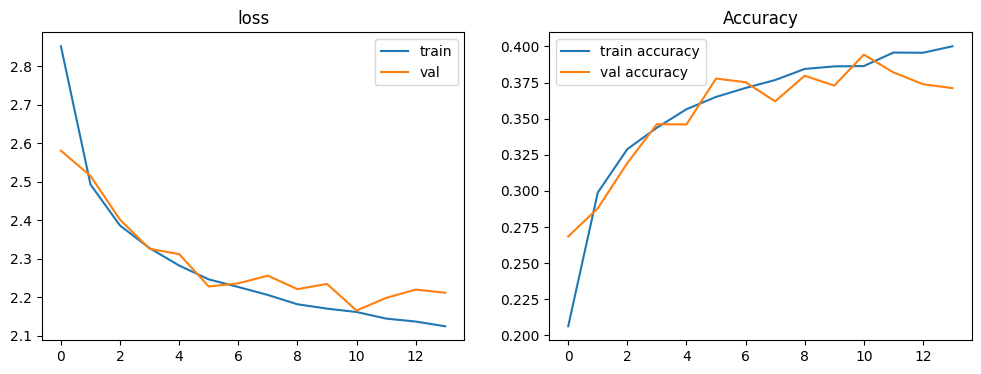

In [58]:
plot_history(history)

In [61]:
res = model.evaluate([X_test_pad2, X_test_picture_features_array], y_test, verbose=0)
print(f'The accuracy evaluated on the test set is of {res[1]*100:.3f}%')

The accuracy evaluated on the test set is of 37.579%


In [62]:
y_pred_full = model.predict([X_test_pad2, X_test_picture_features_array])
y_pred = np.argmax(y_pred_full, axis=1)

179/179 [==============================] - 1s 8ms/step


In [64]:
y_test_or = pd.read_csv("../raw_data/test_y.csv", delimiter=" ", index_col="Id")['Genre_id']

In [65]:
top_k_accuracy = top_k_accuracy_score(y_test_or, y_pred_full, k=3)
print(f'Top 3 accuracy: {top_k_accuracy*100:.2f}%')

Top 3 accuracy: 60.98%


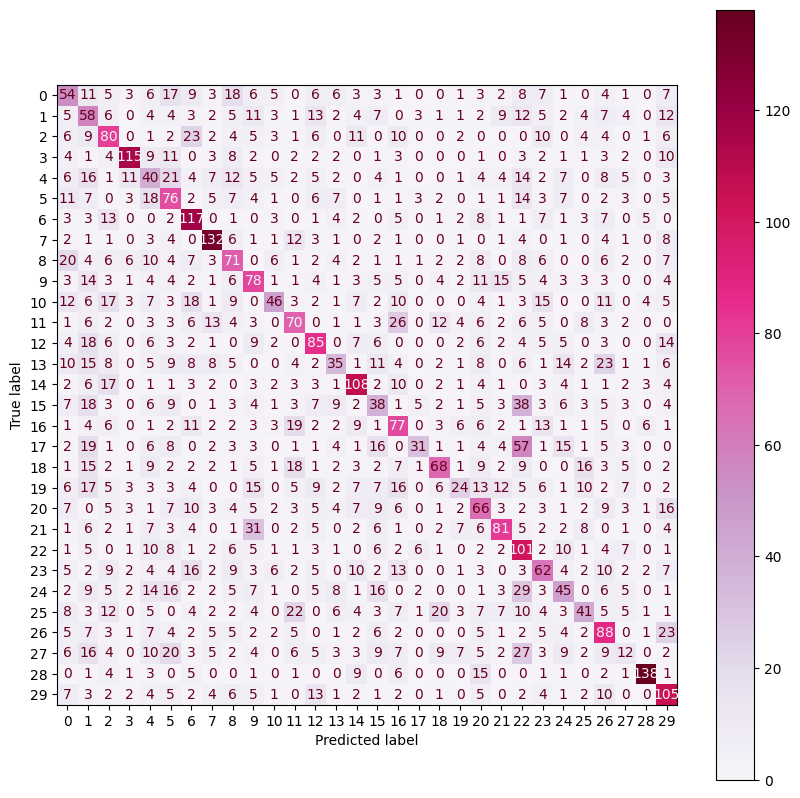

In [66]:
cm = confusion_matrix(y_test_or, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(cmap="PuRd", ax=ax)

### 8 categories

In [67]:
def init_model():
    # Input layers
    input_1 = Input(shape=(100,50)) # embeddings input shape
    input_2 = Input(shape=(8,)) # nahia features input shape
    
    # Masking layer
    masked = Masking()(input_1)
    
    # LSTM
    lstm = LSTM(50, activation='tanh', dropout=0.2, recurrent_dropout=0.2)(masked)
    
    # Concatenate LSTM output with additional input
    concatenated = Concatenate()([lstm, input_2])
    
    # dense layers
    dense2 = Dense(8, activation='softmax')(concatenated)
    
    # Create model
    model = Model(inputs=[input_1, input_2], outputs=dense2)
    
    # Compile model
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    
    return model

model = init_model()  

In [71]:
#es = EarlyStopping(patience=10, restore_best_weights=True, monitor='val_accuracy')
es = EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)

history = model.fit([X_train_pad2, X_train_picture_features_array], y_train_umbr, 
          batch_size = 64,
          epochs=100,
          validation_split=0.1,
          callbacks=[es]
         )

Epoch 1/100
722/722 [==============================] - 48s 65ms/step - loss: 1.6494 - accuracy: 0.4018 - val_loss: 1.4299 - val_accuracy: 0.5251
Epoch 2/100
722/722 [==============================] - 45s 62ms/step - loss: 1.4816 - accuracy: 0.4712 - val_loss: 1.4027 - val_accuracy: 0.5211
Epoch 3/100
722/722 [==============================] - 46s 64ms/step - loss: 1.4258 - accuracy: 0.4944 - val_loss: 1.3488 - val_accuracy: 0.5452
Epoch 4/100
722/722 [==============================] - 45s 62ms/step - loss: 1.3911 - accuracy: 0.5090 - val_loss: 1.3080 - val_accuracy: 0.5536
Epoch 5/100
722/722 [==============================] - 46s 64ms/step - loss: 1.3674 - accuracy: 0.5169 - val_loss: 1.2523 - val_accuracy: 0.5793
Epoch 6/100
722/722 [==============================] - 45s 62ms/step - loss: 1.3456 - accuracy: 0.5270 - val_loss: 1.2217 - val_accuracy: 0.6023
Epoch 7/100
722/722 [==============================] - 47s 64ms/step - loss: 1.3305 - accuracy: 0.5309 - val_loss: 1.2214 - val_ac

(<AxesSubplot:title={'center':'loss'}>,
 <AxesSubplot:title={'center':'Accuracy'}>)

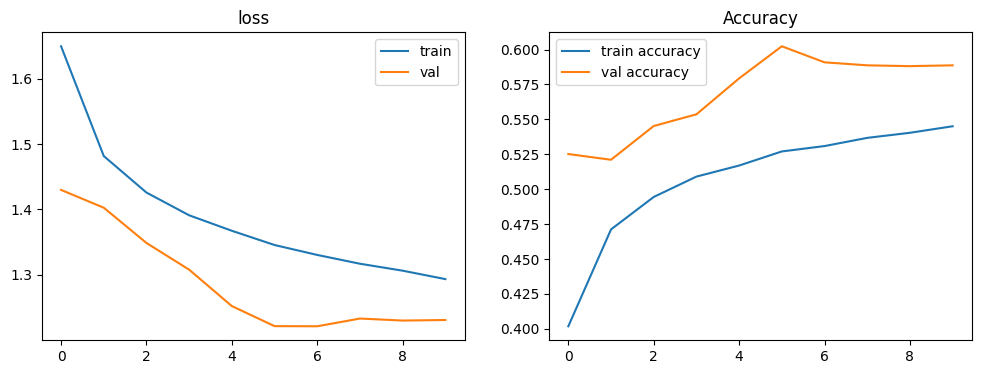

In [72]:
plot_history(history)

In [73]:
res = model.evaluate([X_test_pad2, X_test_picture_features_array], y_test_umbr, verbose=0)
print(f'The accuracy evaluated on the test set is of {res[1]*100:.3f}%')

The accuracy evaluated on the test set is of 54.246%


In [74]:
y_pred_full = model.predict([X_test_pad2, X_test_picture_features_array])
y_pred = np.argmax(y_pred_full, axis=1)

179/179 [==============================] - 2s 8ms/step


In [91]:
y_test_umbr_or = y_umbr_test_df['Genre_umbr_id'].astype(int)

In [100]:
top_k_accuracy = top_k_accuracy_score(y_test_umbr_or, y_pred_full, k=3)
print(f'Top 3 accuracy: {top_k_accuracy*100:.2f}%')

Top 3 accuracy: 26.81%
